In [1]:
from astropy.io import fits
import pandas as pd
from gatspy import periodic
import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick',c='w')
plt.rc('ytick',c='w')
from PyAstronomy import pyasl
from astropy.time import Time
import lightkurve as lk
from astropy import units as u
from astropy.modeling import Fittable1DModel, Parameter
from astropy.modeling import models, fitting
from matplotlib import gridspec
from lmfit import Parameters, minimize, report_fit, Model,fit_report
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.coordinates import ICRS
from pylab import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.timeseries import LombScargle
from matplotlib import transforms
from pylab import *
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
from specutils.analysis import snr_derived
from scipy.stats import norm
from specutils import Spectrum1D, SpectralRegion

/home/nwal/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def Read_Three_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        shift = []
        for line in data:
            p = line.split()
            shift.append(float(p[0]))
            x.append(float(p[1]))
            y.append(float(p[2]))

    return x, y,shift
def sineModel(x,a,b,c,d):
    return a*np.sin(b*x+c)+d

def sineModelFix(x,a,c,d):
    return a*np.sin(2*np.pi*x+c)+d

def foldMeth(timeArray, period):
    phases = []
    for el in timeArray:
        passed = int(el/period)
        leftover = el - (passed*period)
        phase = leftover/period
        phases.append(phase)
    return np.array(phases)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def gaussian(x, amp, cen, wid, off):
    return (amp * np.exp(-(x-cen)**2 / wid))+off

def lorentzian(x, x0, a, gam,off):
    return (a * gam**2 / ( gam**2 + ( x - x0 )**2))+off
def lorentzianGauss(x, x0, a, gam, off, amp,wid,off2):
    return lorentzian(x,x0,a,gam,off)+gaussian(x,amp=amp,cen=x0,wid=wid,off=off2)

In [4]:
#isaac
#x28Ph, y28Ph,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/28/shiftedAir.txt')
#x28Ph, y28Ph,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/28/fxcorPhoenixPy.txt')
#x28Ph, y28Ph,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/28/Sonora28Short.txt')
#latest#x28Ph, y28Ph,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/28/SonoraDown28.txt')
x28Ph, y28Ph,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/28/SonoraBestCCText.txt')

x28PhNew, y28PhNew,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/28/heade/headersSlim.txt')
path = '/home/nwal/Desktop/GD1400/oct28/all/proc2/'
airmasses = []
with open(path+'ToCont') as f:
    content = f.readlines()
content = [x.strip() for x in content] 
times = []
for el in content:
    fits_image_filename = path+el
    hdul = fits.open(fits_image_filename)
    hdr = hdul[0].header
    timeHeader = hdr.comments['UTC'][:10]
    expTime = hdr['EXPTIME']
    date = hdr['DATE-OBS']
    airmass = hdr['HIERARCH ESO TEL AIRM START']
    airmasses.append(airmass)
    t = Time(date, format='isot', scale='utc')
    t = t + (expTime/2*u.second)
    times.append(t.jd)
times28 = times
#x29Ph, y29Ph,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/29/shiftedAir.txt')
#x29Ph, y29Ph,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/29/fxcorPhoenixPy.txt')
#x29Ph, y29Ph,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/29/Sonora29Short.txt')
#latest#x29Ph, y29Ph,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/29/SonoraDown29.txt')
x29Ph, y29Ph,_= Read_Three_Column_File('/home/nwal/Desktop/GD1400/jayCor/29/SonoraBestCCText.txt')
path = '/home/nwal/Desktop/GD1400/oct29/all/forProc2/'
with open(path+'CleanFrames') as f:
    content = f.readlines()
content = [x.strip() for x in content] 
times = []
airmasses = []
for el in content:
    fits_image_filename = path+el
    hdul = fits.open(fits_image_filename)
    hdr = hdul[0].header
    timeHeader = hdr.comments['UTC'][:10]
    expTime = hdr['EXPTIME']
    date = hdr['DATE-OBS']
    t = Time(date, format='isot', scale='utc')
    airmass = hdr['HIERARCH ESO TEL AIRM START']
    airmasses.append(airmass)
    t = t + (expTime/2*u.second)
    times.append(t.jd)
times29 = times

allT = np.concatenate((times28,times29))

esovlt = EarthLocation.from_geodetic(lat=-24.6275*u.deg, lon=-70.4044*u.deg, height=2635*u.m)
sc = SkyCoord("01:47:21.8246239967 -21:56:51.387203270", frame=ICRS, unit=(u.hourangle, u.deg))
baryCorr = []
for el in np.array(times28)-2400000.5:
    barycorr = sc.radial_velocity_correction(obstime=Time(el, format='mjd'), location=esovlt)  
    baryCorr.append(barycorr.to(u.km/u.s).value)

ISAACT1 = np.array(times28)-2400000.5
ISAACY1 = np.array(x28Ph) + np.array(baryCorr)
ISAACE1 = y28Ph

esovlt = EarthLocation.from_geodetic(lat=-24.6275*u.deg, lon=-70.4044*u.deg, height=2635*u.m)
sc = SkyCoord("01:47:21.8246239967 -21:56:51.387203270", frame=ICRS, unit=(u.hourangle, u.deg))
baryCorr = []
for el in np.array(times29)-2400000.5:
    barycorr = sc.radial_velocity_correction(obstime=Time(el, format='mjd'), location=esovlt)  
    baryCorr.append(barycorr.to(u.km/u.s).value)
ISAACT2 = np.array(times29)-2400000.5
ISAACY2 = np.array(x29Ph) + np.array(baryCorr)
ISAACE2 = y29Ph

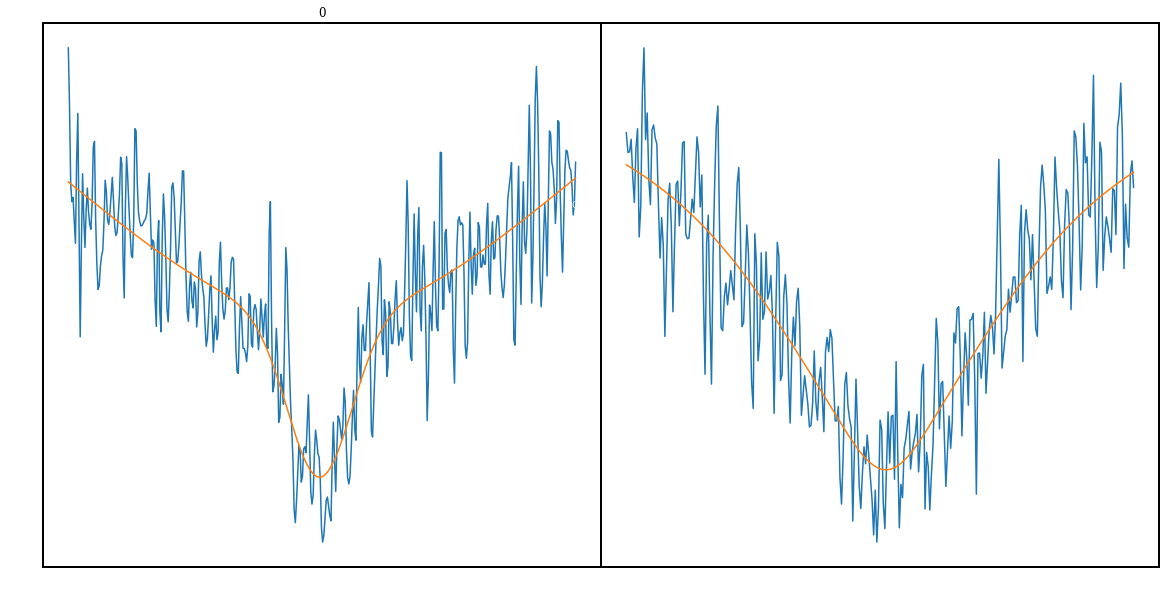

Parameters([('cen', <Parameter 'cen', value=3.8171325236441134, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.22412521830529797, bounds=[-inf:inf]>), ('gamA', <Parameter 'gamA', value=0.0006935571292101664, bounds=[-inf:inf]>), ('offAL', <Parameter 'offAL', value=-651607.2302711187, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.06571940581797175, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=651607.8293261898, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.2592976885837296, bounds=[-inf:inf]>), ('gamB', <Parameter 'gamB', value=0.00025636347201753656, bounds=[-inf:inf]>), ('offBL', <Parameter 'offBL', value=-562166.0004832684, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.02055745461534353, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=562166.9006209263, bounds=[

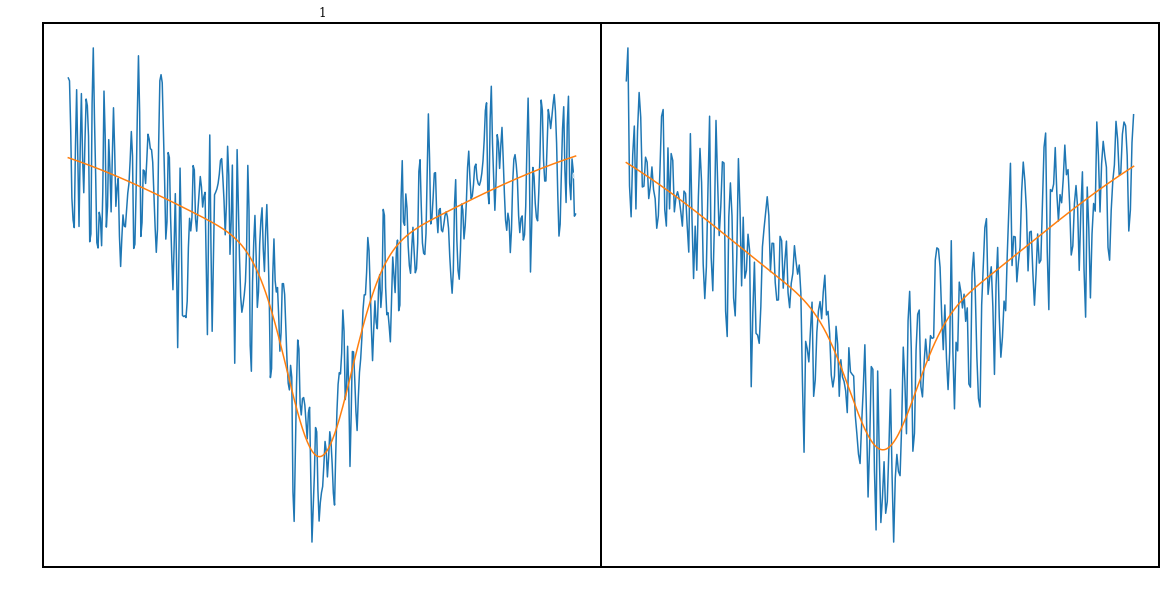

Parameters([('cen', <Parameter 'cen', value=3.8171341433407213, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.06469146583569918, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0003565752529997024, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=-235296.25659929033, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.07563221334077719, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=235296.6997763628, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.23358803329364242, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0004081462896738941, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=82411.62080056788, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.09287391766455322, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-82410.69390946877, 

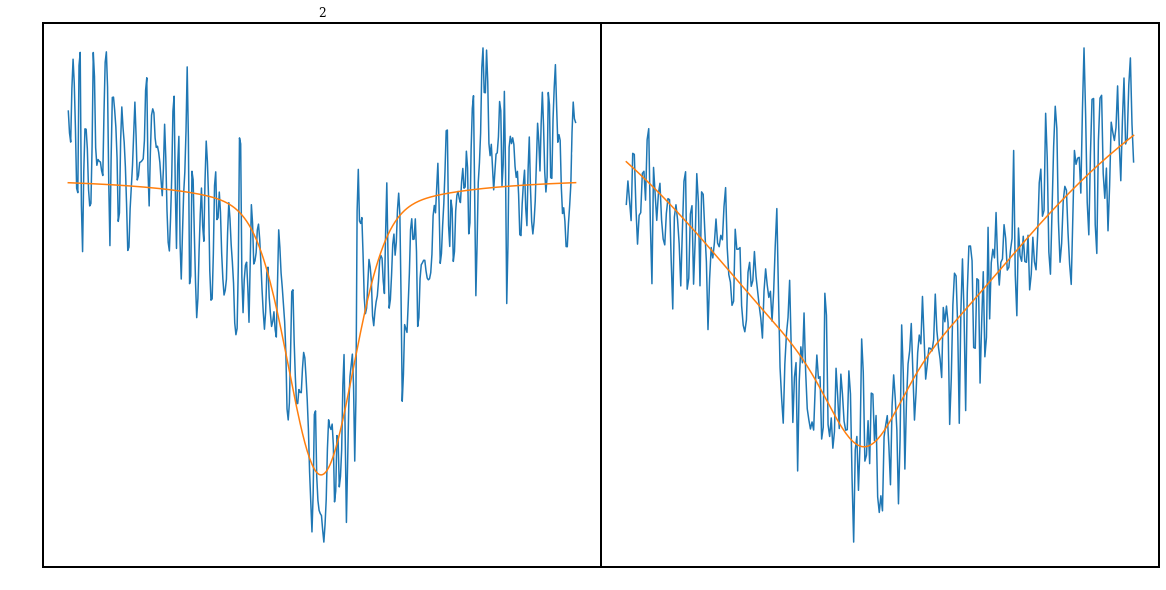

Parameters([('cen', <Parameter 'cen', value=3.8171423698809854, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.01823829964237733, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.00014213157900622164, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=1378850.8717835287, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.09747170667575467, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=-1378850.4596593468, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.30141673748326814, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0003733127479128573, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=-590461.674815131, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.050916185420885274, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=590462.6188952436

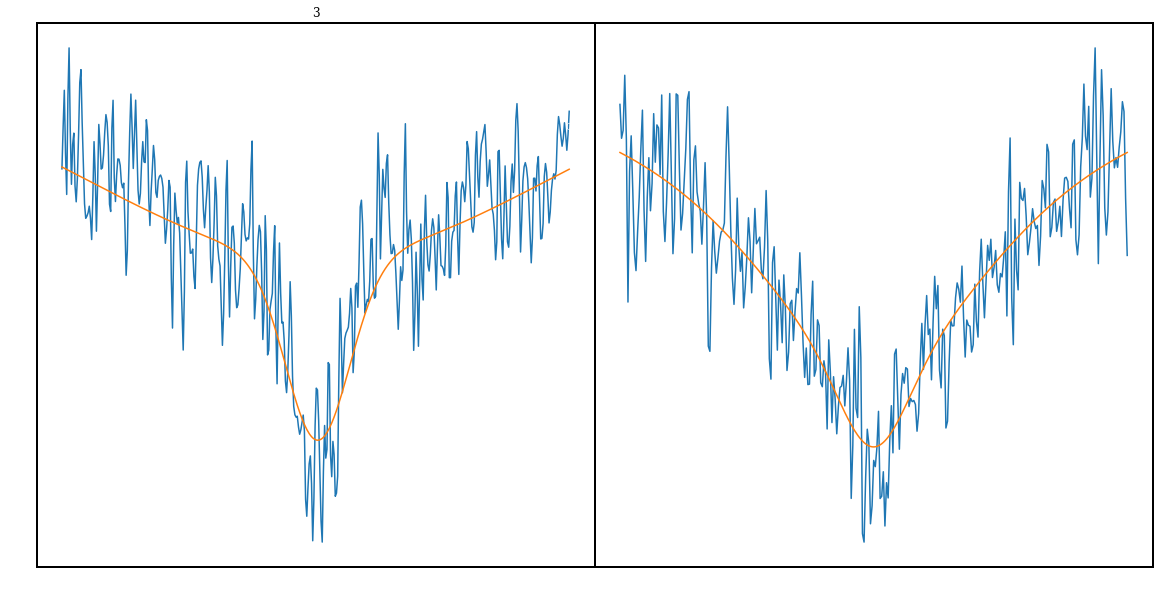

Parameters([('cen', <Parameter 'cen', value=3.8171434355873077, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.13693341185957797, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0006497446835118659, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=6812.060025887213, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.0756582124972045, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=-6811.5451574858325, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.2066259639235304, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00026238537343004076, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=111891.88552321939, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.04961113718256338, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-111891.04039842632,

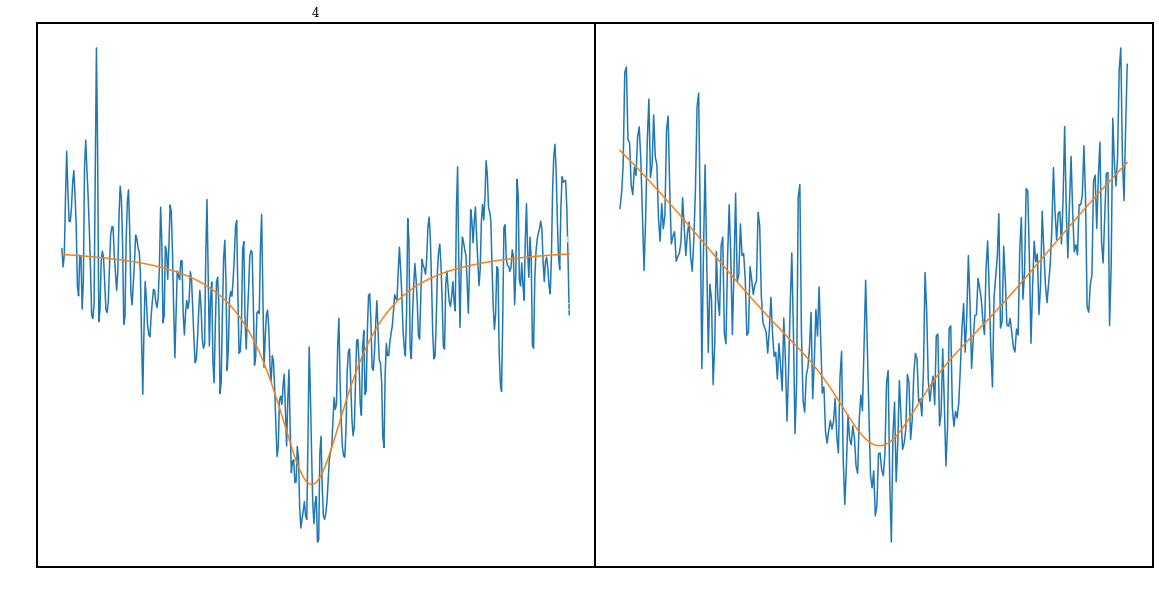

Parameters([('cen', <Parameter 'cen', value=3.8170870321073105, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.10464658469383403, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=7.383006250694102e-05, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.06839846142183231, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.0001090640147416444, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.34839845051432206, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.3883589182491365, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00045592332075439224, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=0.5404721503213032, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.045787231276053886, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.490472327653

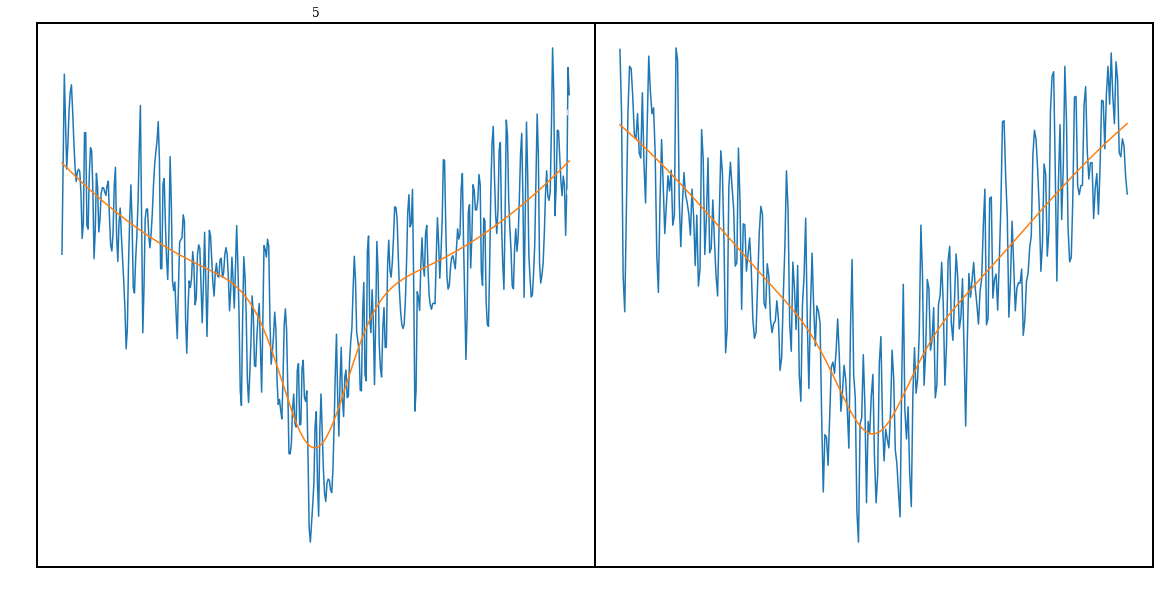

Parameters([('cen', <Parameter 'cen', value=3.8170879714299235, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-54.85129657646413, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.012491755958485395, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=27.478223666547905, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.0676466384137655, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=27.755060582007832, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.27619127827508483, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0003975551403272437, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=1.2354429763426111, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.054379237383910595, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-0.3056416298504629, b

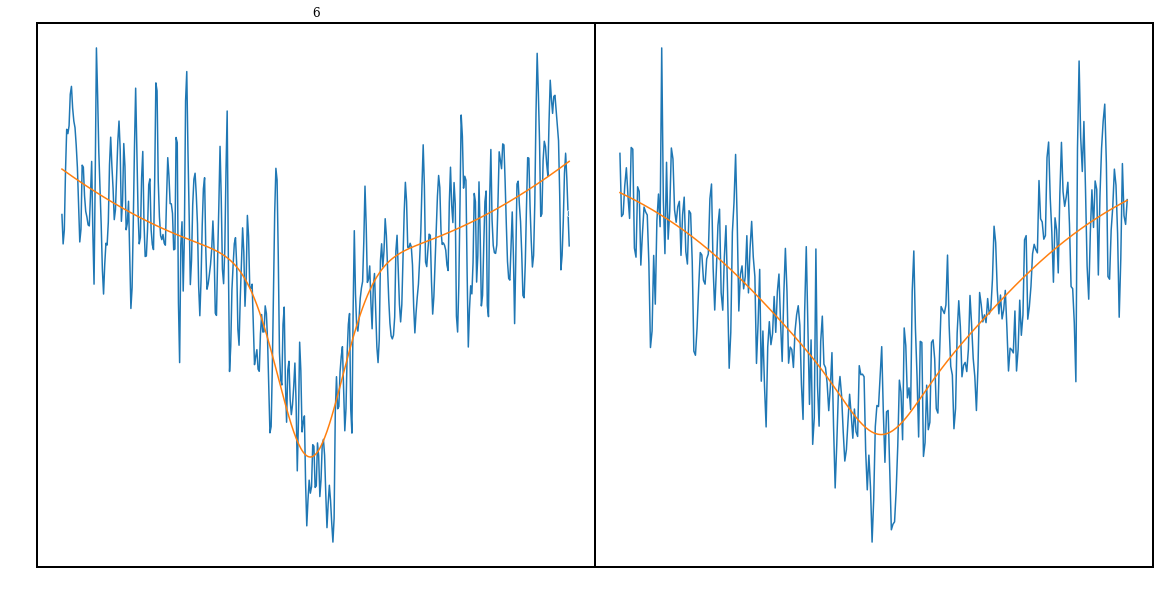

Parameters([('cen', <Parameter 'cen', value=3.8170998147485844, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-1.0210505482772105, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0019387708086047173, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.5630266354978698, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.08367779685547716, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.843017421696737, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.23970968770366397, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00027651866621991594, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=0.470853523152441, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.034966689110393245, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.4208355985617179, 

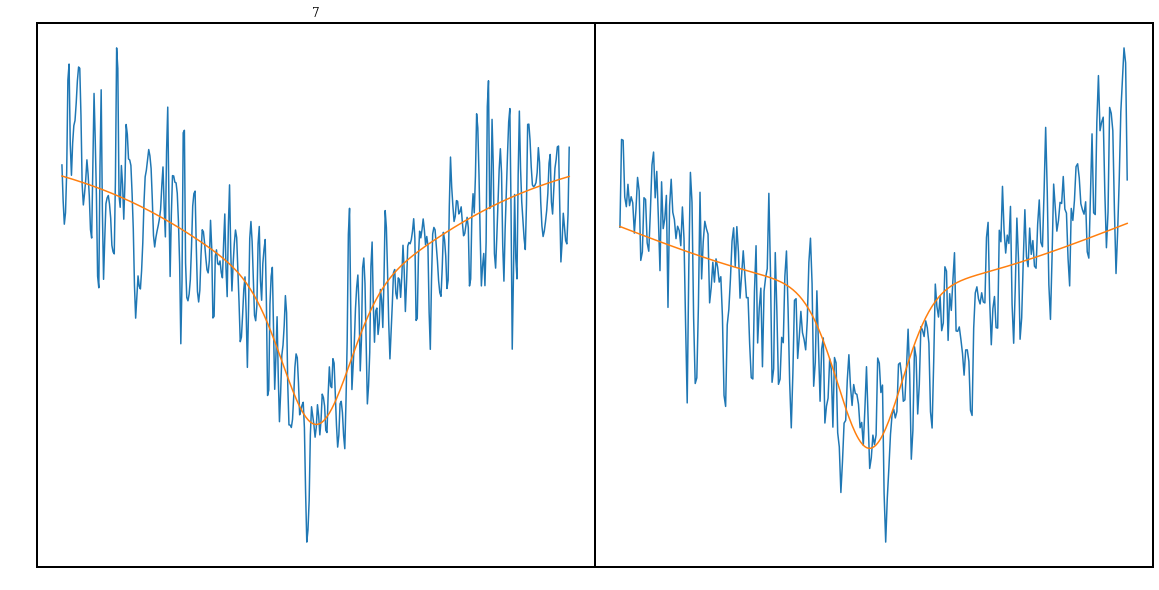

Parameters([('cen', <Parameter 'cen', value=3.8171130158024464, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.08284798225900403, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.00026384360274178675, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.04691812569820744, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.059888642894655675, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.40442322887965104, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.2325752023546015, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0007372950879307449, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=-106717.19284951907, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.13332312738933894, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=106718.15409311

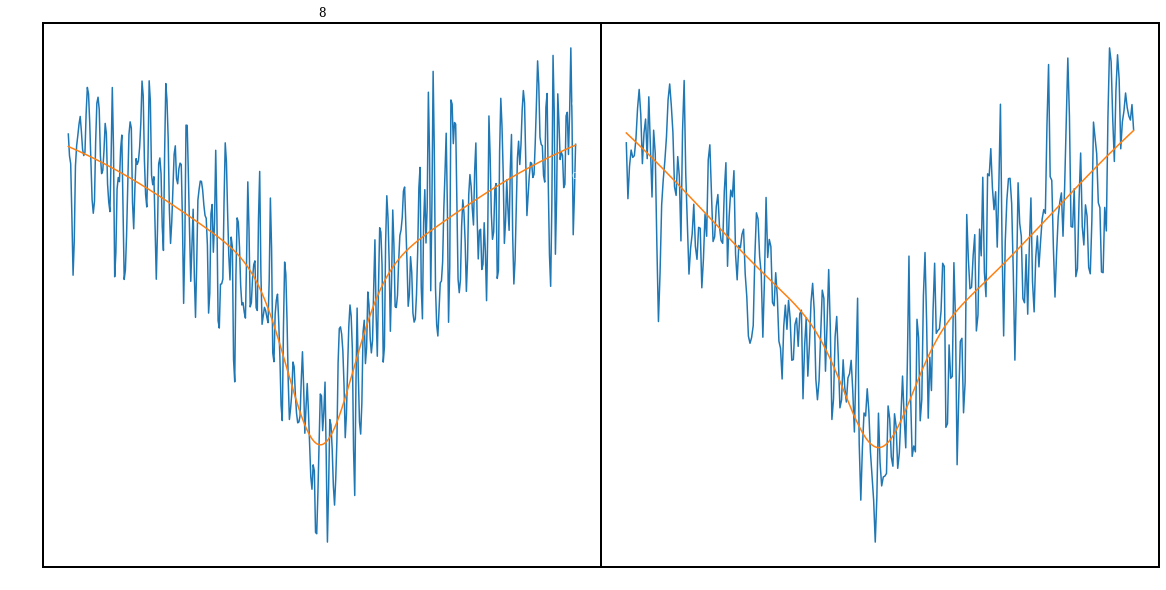

Parameters([('cen', <Parameter 'cen', value=3.817075619696025, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.0891144638568393, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.000335001148718872, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=-137018.55906409767, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.06567559773333875, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=137019.02433220338, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.33711899456265537, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00046633381020999565, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=-100538.54772581071, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.07693166322716016, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=100539.57270903936,

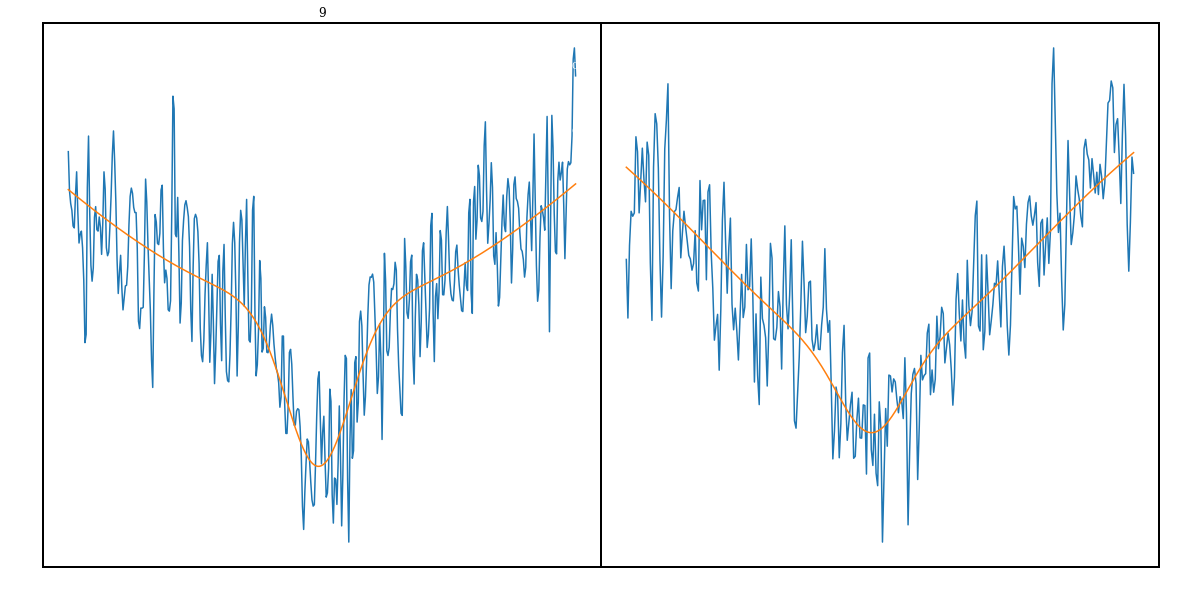

Parameters([('cen', <Parameter 'cen', value=3.817085838243375, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.36936268755286106, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0010120451294437505, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=2067.077268156239, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.06565194866727375, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=-2066.325934769451, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.34282875597849816, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0004470682399662085, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=1.475240956320743, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.057195348278949454, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-0.45761526518101386,

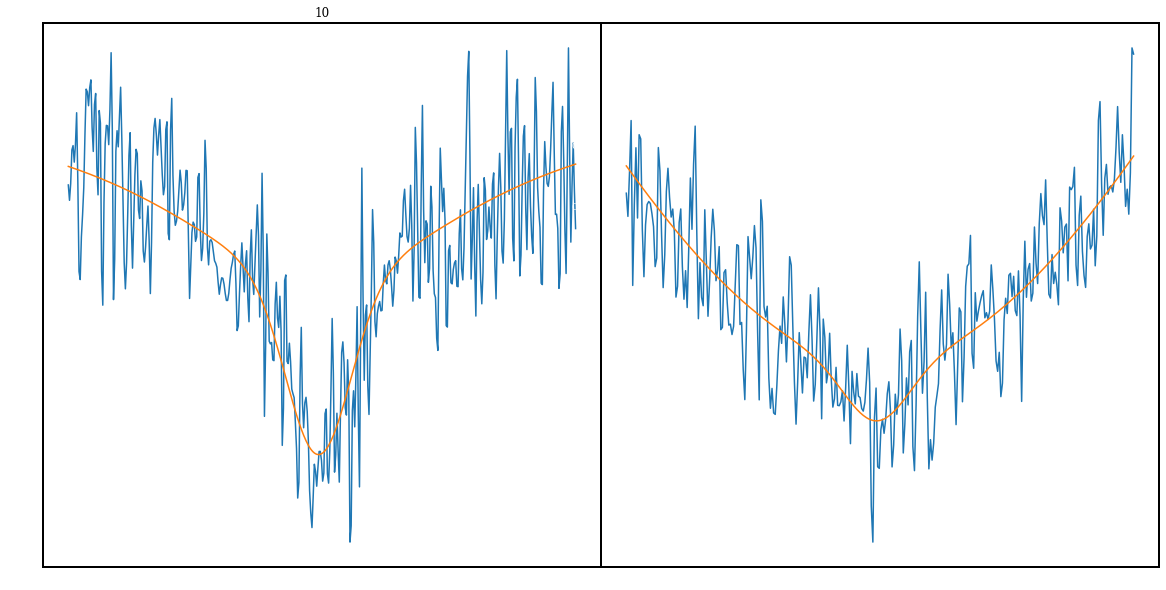

Parameters([('cen', <Parameter 'cen', value=3.817128986952143, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.07211289515889874, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0003037682023450117, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.21125186924058031, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.06954329957055183, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.2402298613291183, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-1.3306978906901792, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0010661868488504034, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=1.0074071052222642, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.04738878223320109, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.9955125642958145, 

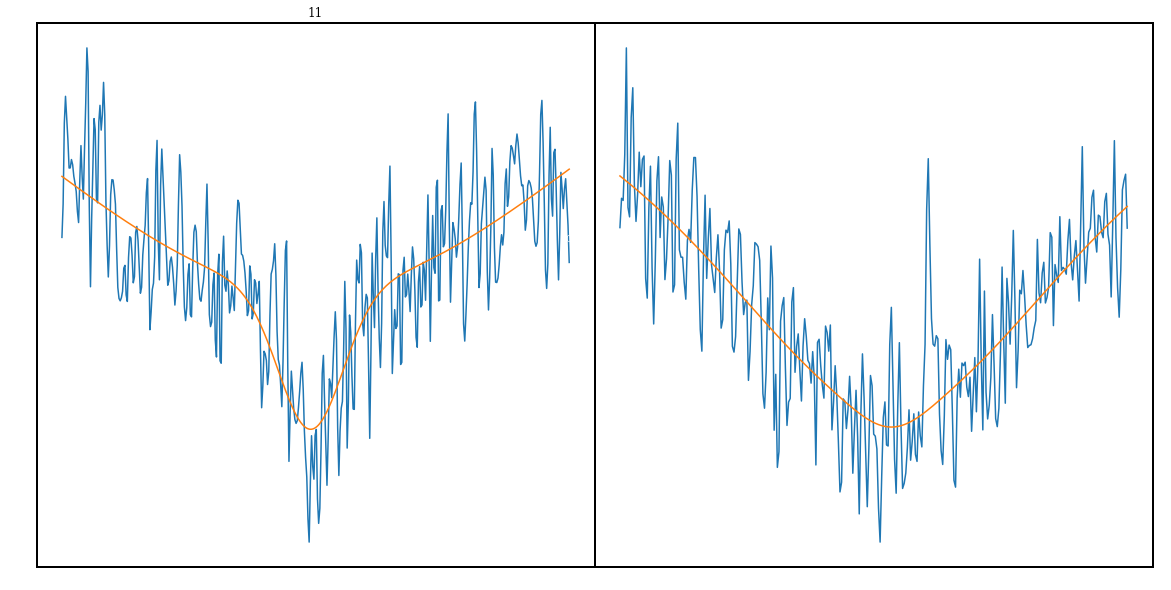

Parameters([('cen', <Parameter 'cen', value=3.817128520407875, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.2617420509019106, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0007768793281817121, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=91962.69789686782, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.06446335320511087, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=-91962.05545967055, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.3470526112157102, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00039423718488929005, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=8749.16455934685, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.013430785572255965, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-8748.155354247503, bou

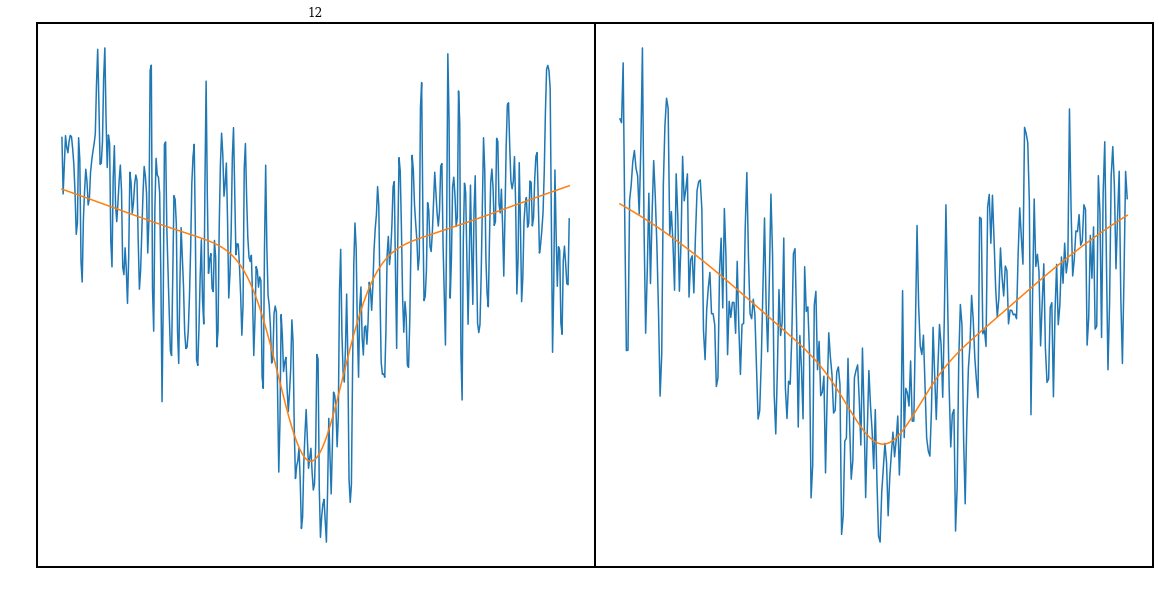

Parameters([('cen', <Parameter 'cen', value=3.817090249200388, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.08890872239585268, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0005445347755412833, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.07076588866581046, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.09449763706612813, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.4099201412788438, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.25795866674010015, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0003587977086960681, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=106856.95684508722, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.05570007407500588, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-106856.05847700902

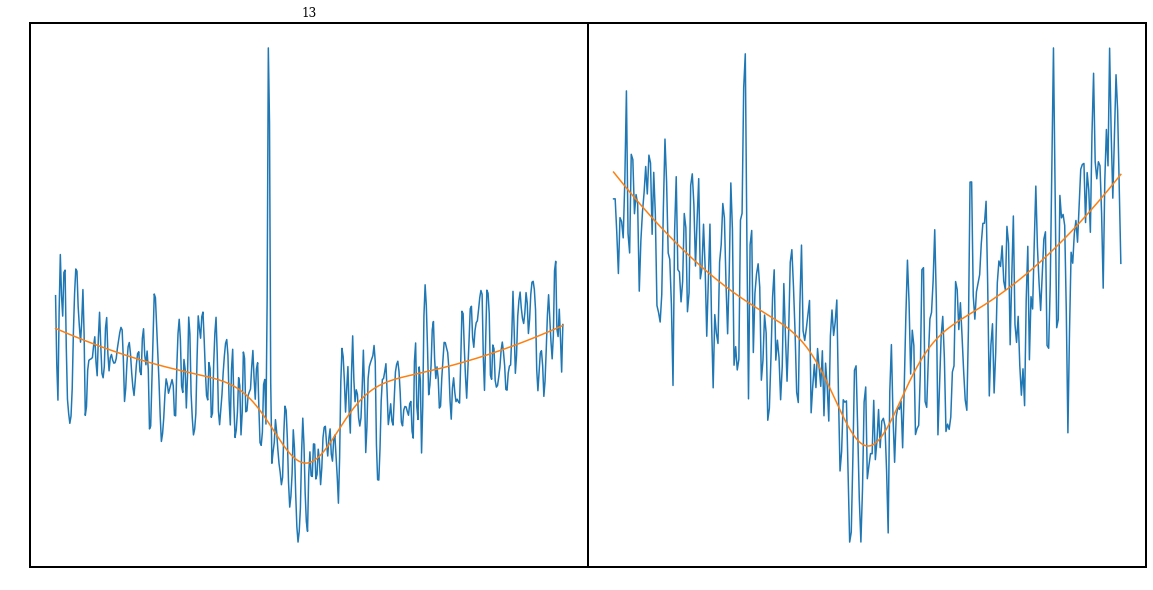

Parameters([('cen', <Parameter 'cen', value=3.8170917510658717, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-1.3581359585799704, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0020068290423500557, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.7344679541389151, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.06952626990755495, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=1.0073757226716735, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-2.9483198433391693, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0017137910076039375, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=106935.85947214403, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.09425513366913851, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-106932.22568781073, 

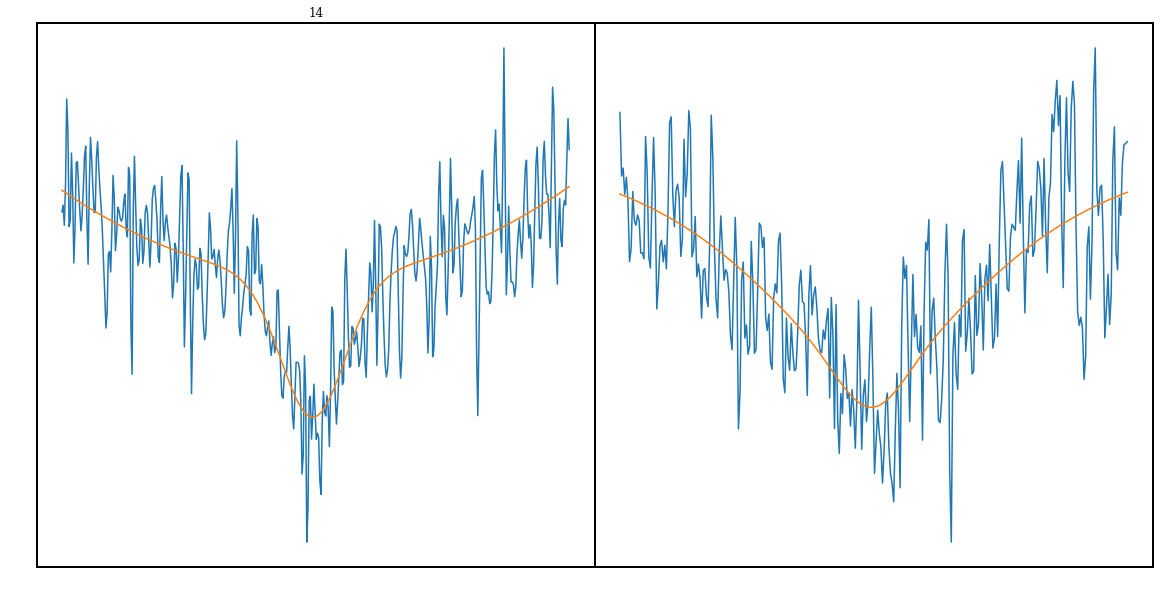

Parameters([('cen', <Parameter 'cen', value=3.8171132598563595, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-22.966044706107375, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.008498919067873256, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=11.538392973772497, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.08128824156357006, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=11.816715948501678, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.20767651775383356, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0002561341636164727, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=0.4799385151423309, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.037451079782299, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.3587917689270344, bou

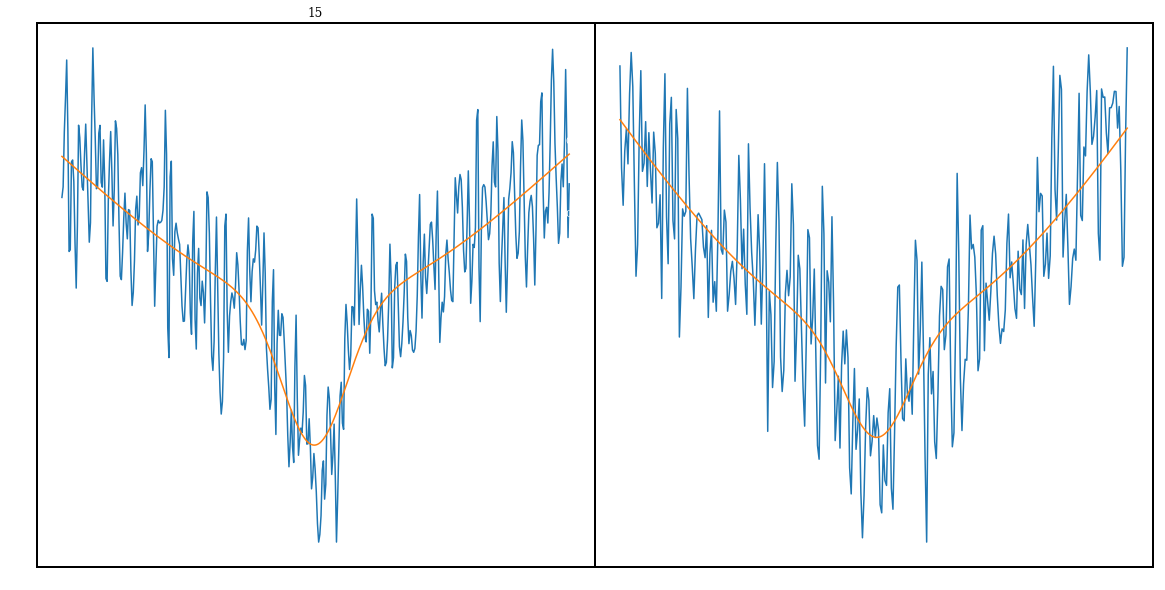

Parameters([('cen', <Parameter 'cen', value=3.81711547982357, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.2769094369881311, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0007119696183628399, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=-91978.61881748051, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.06456487066166106, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=91979.27229366751, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.7730168211123967, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0008363854622595035, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=12874.406552281891, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.07022679300187162, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-12872.96582865186, boun

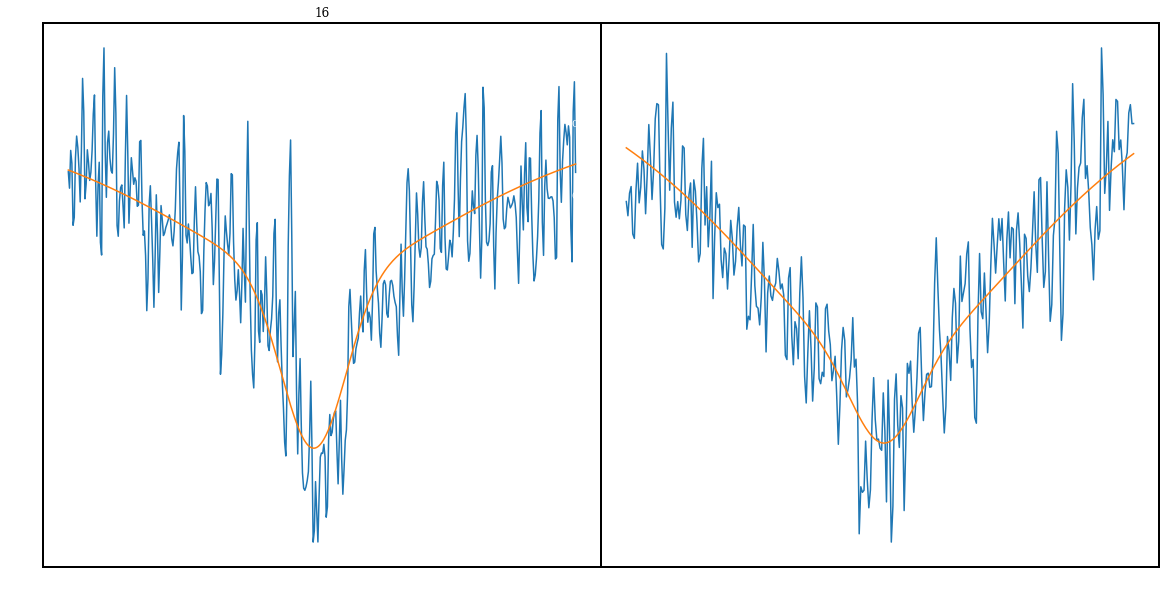

Parameters([('cen', <Parameter 'cen', value=3.817127112269579, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.07364995496003757, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0003503006776786055, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.09915552736909705, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.06743900579039497, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.3476138569394843, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.2587499776569766, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00034885316667709887, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=0.5087088584850624, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.05783456433660428, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.4343385656990634,

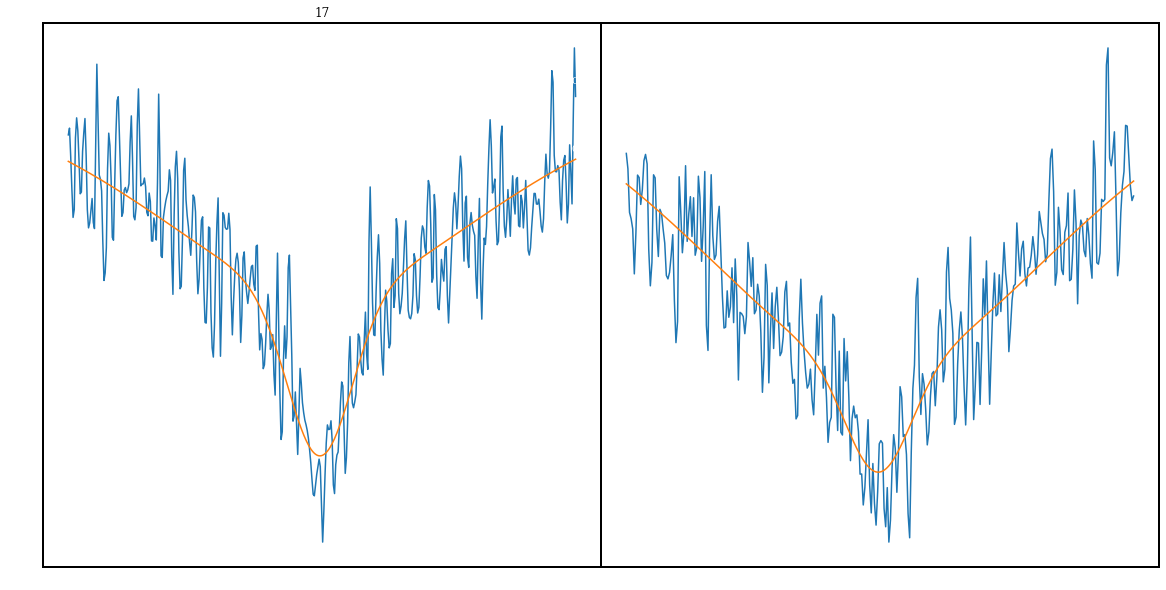

Parameters([('cen', <Parameter 'cen', value=3.8171292889224624, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.10721570694621185, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.00040188734181167973, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.18216602402684406, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.06491765682313755, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.2915084272615358, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.30059866776557964, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00044142308918937445, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=0.3589141951394173, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.07637386619147812, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.63130975010298

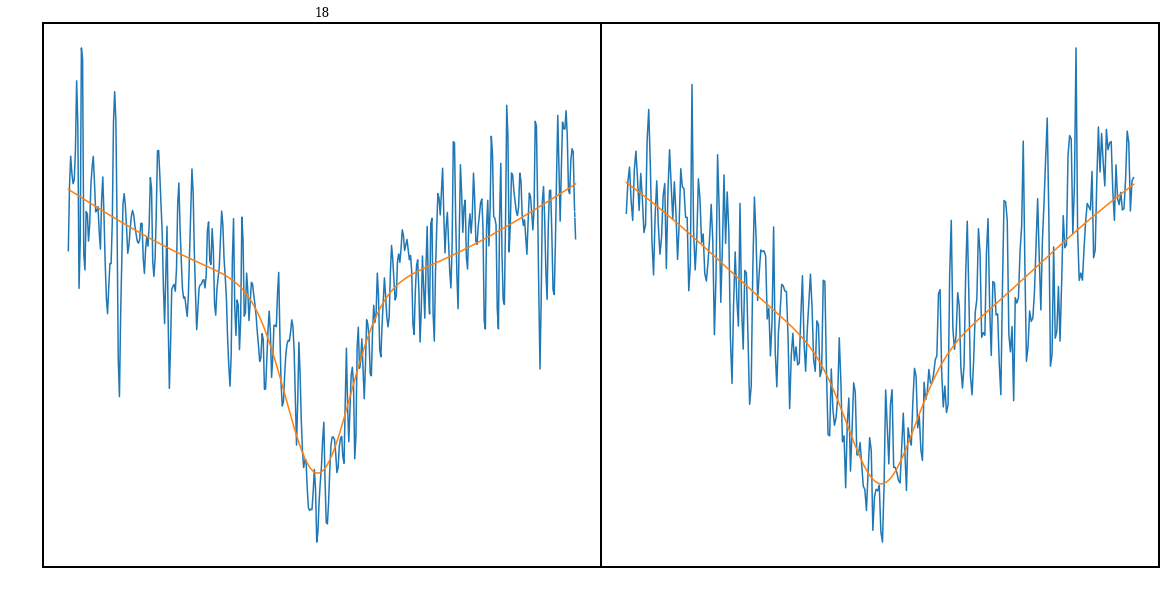

Parameters([('cen', <Parameter 'cen', value=3.8171239402080834, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.18383539620157552, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0007674486851656503, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=252187.7218382427, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.07000584491404849, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=-252187.16022888978, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.24451869031440987, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00041628372866031604, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=-395560.66487681784, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.07902608998325666, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=395561.6119087653

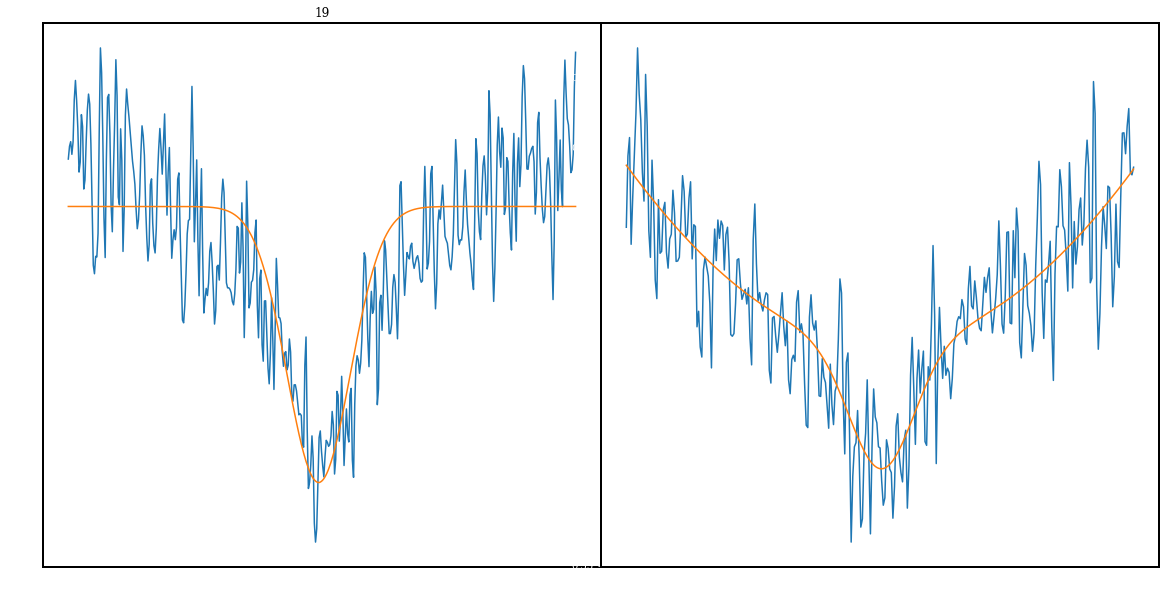

Parameters([('cen', <Parameter 'cen', value=3.8171254169404305, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-8.486069173319066e-05, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=2.5074853235995676e-06, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=10371.324473665936, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.09735391581982722, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=-10370.926654124685, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-4.33270204406236, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0022959753807549887, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=7328.831592141052, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.08898808027985006, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-7323.790475438304,

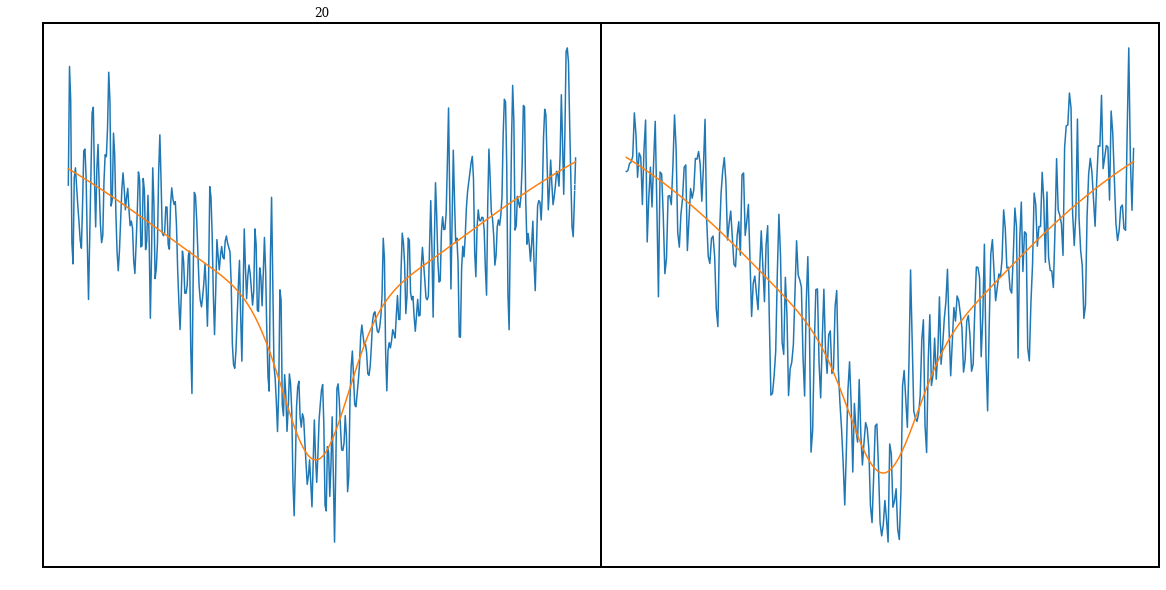

Parameters([('cen', <Parameter 'cen', value=3.817135885958273, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.11314461165359146, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.00041101687761480044, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.48885225920143077, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.05876202947146125, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=-0.005671039291571922, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.21759379378496768, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0003333267271627971, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=1.4427469382417109, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.0774708729523933, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-0.5352015346931

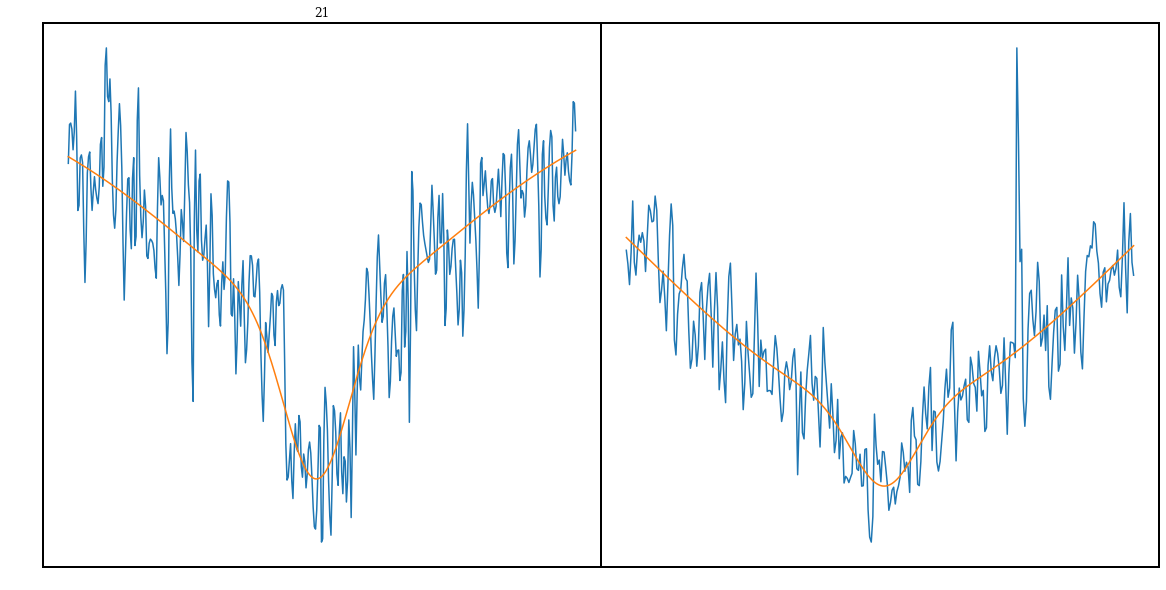

Parameters([('cen', <Parameter 'cen', value=3.8171387241024637, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.10149154709783015, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0003695161329220209, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.020714720961633043, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.05828152552363575, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.4487704167581261, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.5884671325414528, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0006846832393279101, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=0.698698340614462, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.07230831574246244, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.5721491175299926,

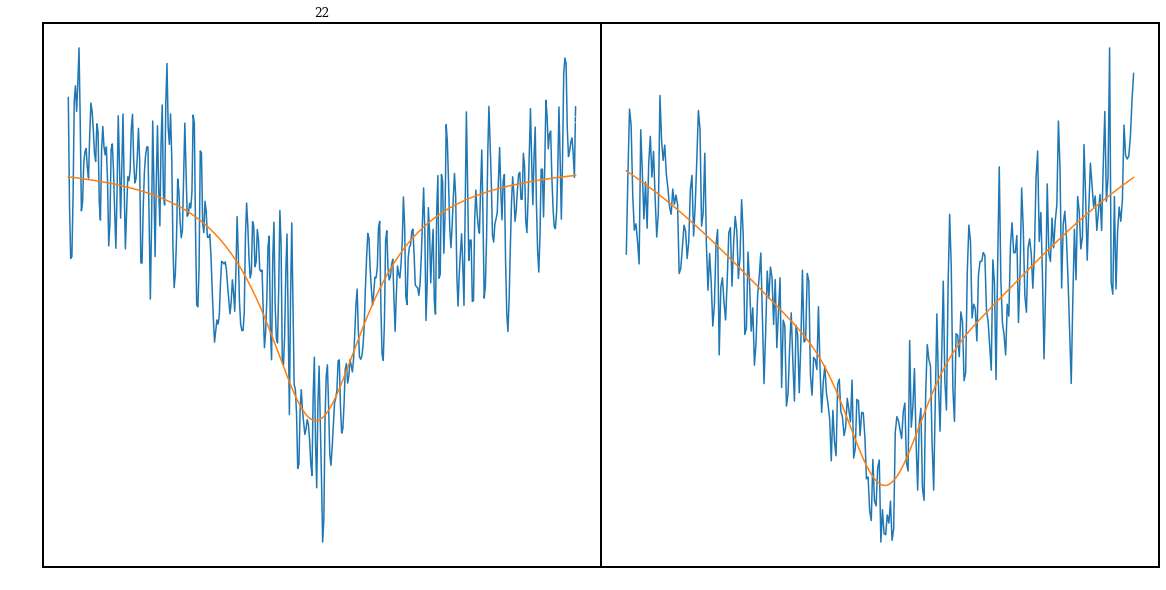

Parameters([('cen', <Parameter 'cen', value=3.8171396389731944, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.10530602100469344, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=9.926068927512688e-05, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.03612560660178754, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-7.398767327471134e-06, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.3811121622743969, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.22012461232929614, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00035684558211879214, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=110699.16340139287, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.07111578358161874, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-110698.2498602

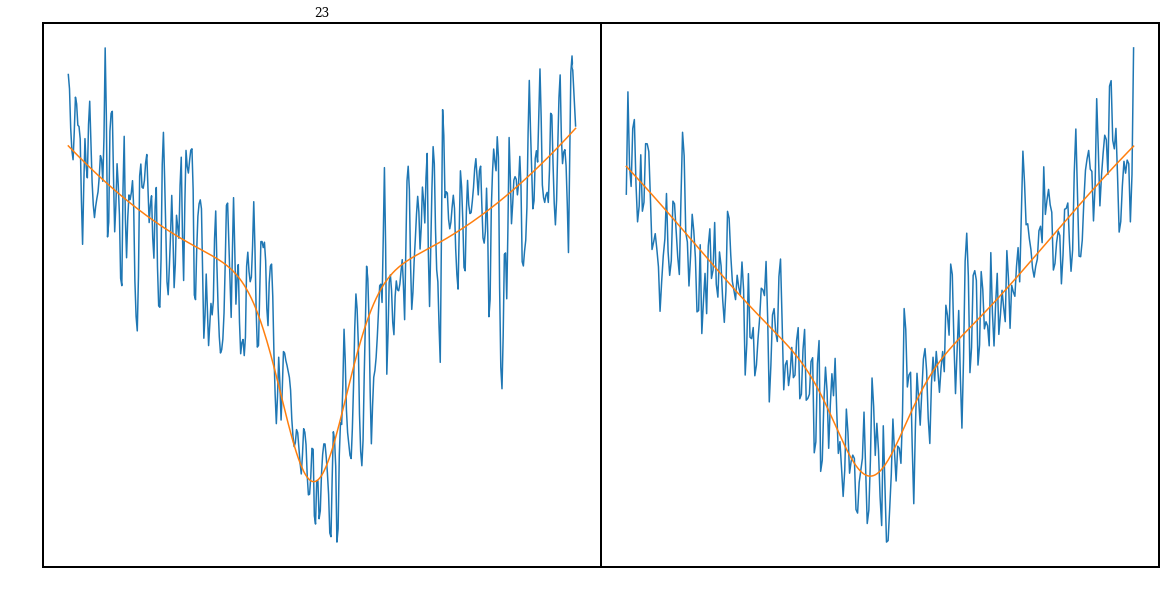

Parameters([('cen', <Parameter 'cen', value=3.81714584831078, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-1.5308695182520835, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.002236508321822317, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.814135197909503, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.06887550967098188, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=1.0941386290789963, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.38858784589234796, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0004816627044048616, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=0.5585844359976129, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.06845323984312723, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.5081964729868494, boun

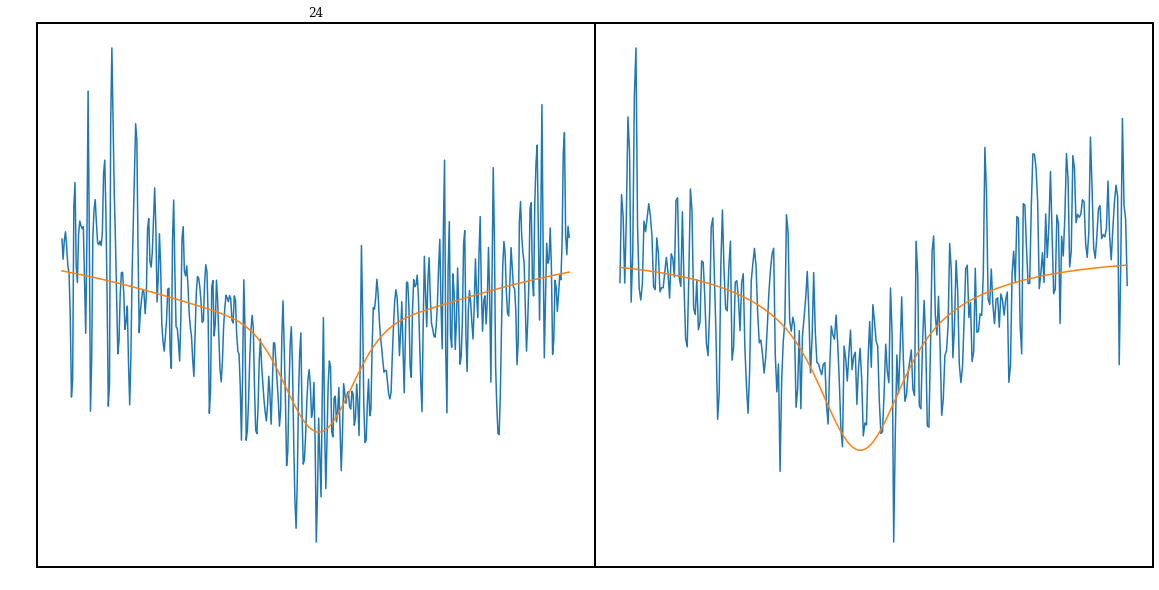

Parameters([('cen', <Parameter 'cen', value=3.8171262340795664, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.0483968507472361, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.00033992392502346647, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=-259056.46285322442, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.04960820960807566, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=259056.9077713765, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.12185612261040024, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0001344681932684555, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=87029.67817039312, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.07034367856634027, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-87028.85516575685, 

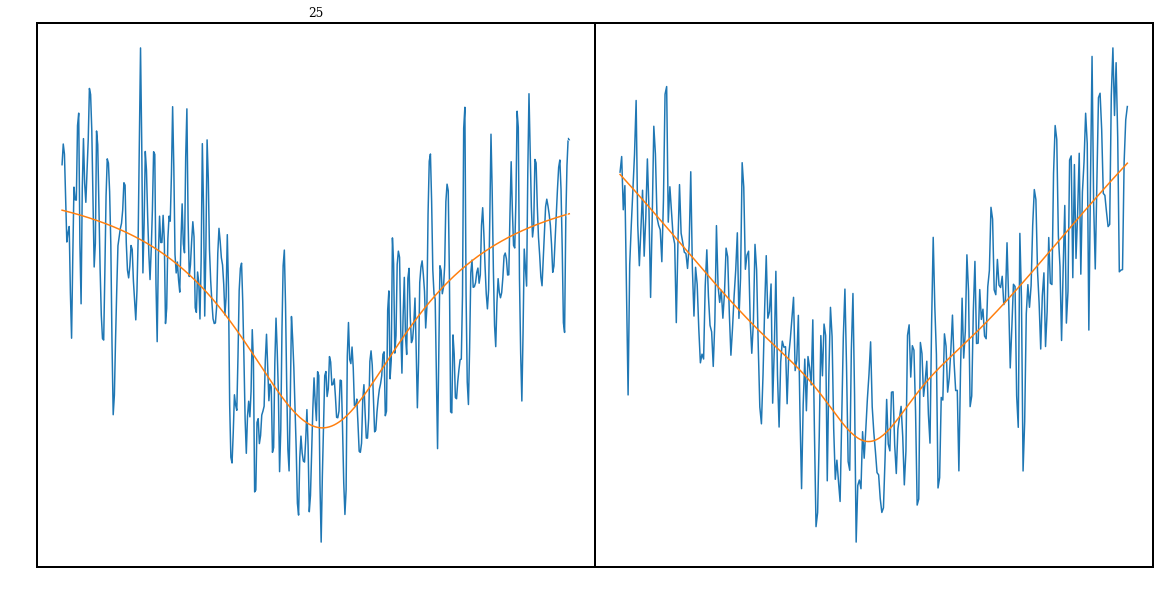

Parameters([('cen', <Parameter 'cen', value=3.8171074341500533, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.08264419719742833, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.00017196882493020205, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.18356499076402413, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-8.051524823970979e-06, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.26093872835883625, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.37426349606517473, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0005123971309288766, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=0.7259594330036218, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.03297287417550088, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.436435974552

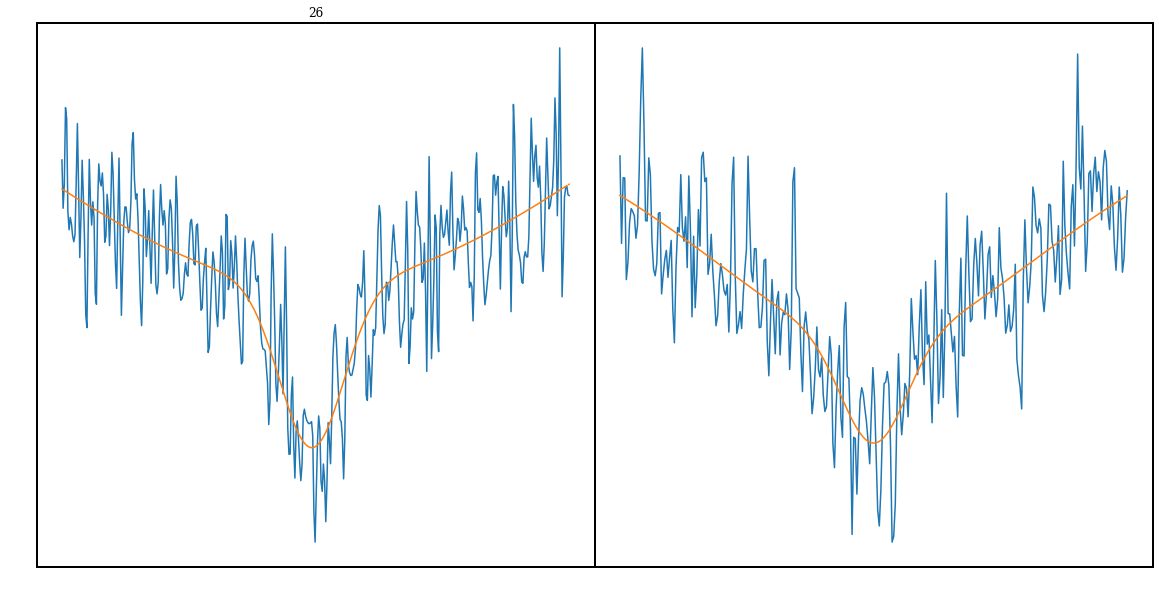

Parameters([('cen', <Parameter 'cen', value=3.8171322517253667, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.26398370754086997, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0008889914445264768, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=32745.954626872426, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.07405830692185966, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=-32745.30968345146, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.2542686585673921, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0004338496138454051, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=152974.89695380878, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.08369864851717879, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-152973.9703514148, 

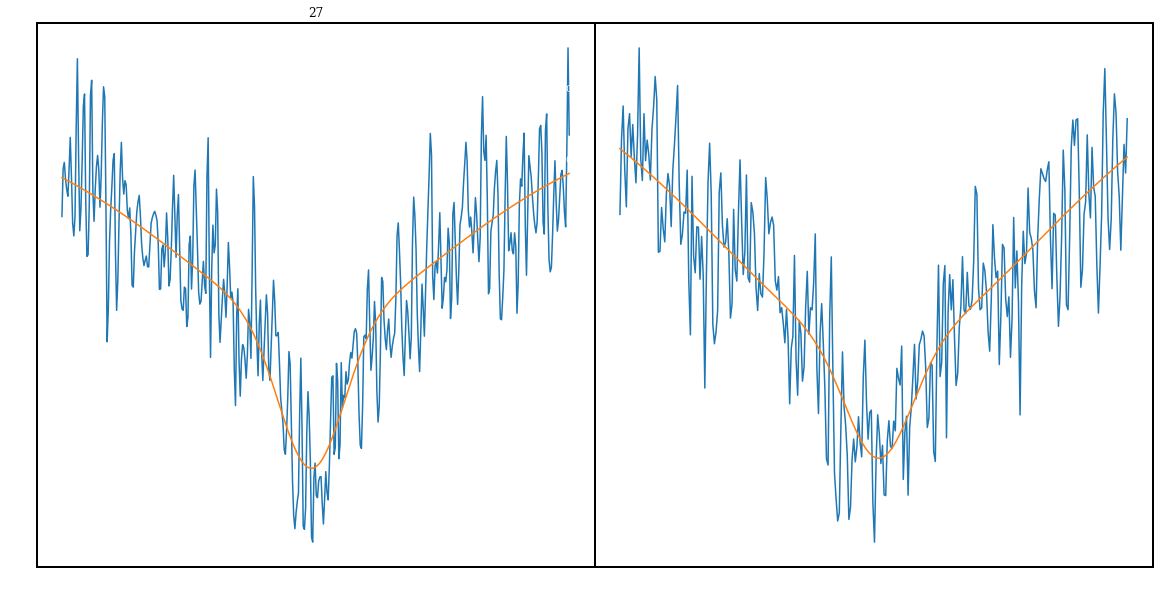

Parameters([('cen', <Parameter 'cen', value=3.8171427628898806, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.1130655983167903, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.00035633072321483716, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=-75437.48487355869, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.062348479394707335, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=75437.96706056727, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.29232010174662193, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.000421880349235515, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=70442.13704510932, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.07576728432126334, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-70441.17843715649, b

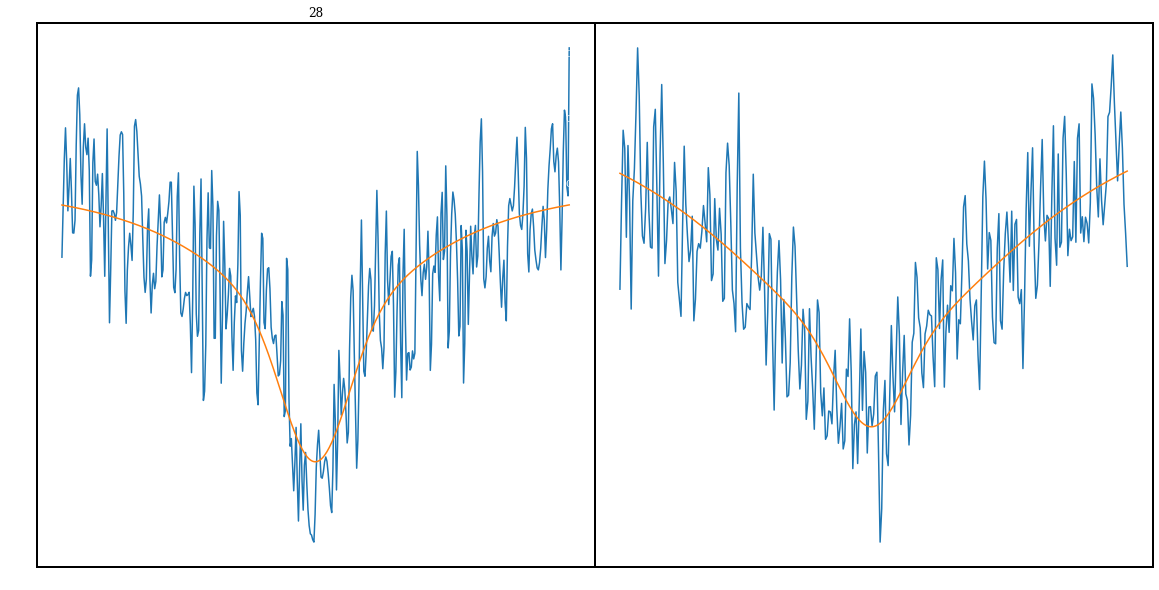

Parameters([('cen', <Parameter 'cen', value=3.8171601202862036, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.06617276374230263, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.00018995451342918024, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=-32821.36580507756, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.056821999100034715, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=32821.793421721326, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.20981588699868747, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00030285771769045233, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=91133.86555787269, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.06228441070124224, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-91132.9799451785

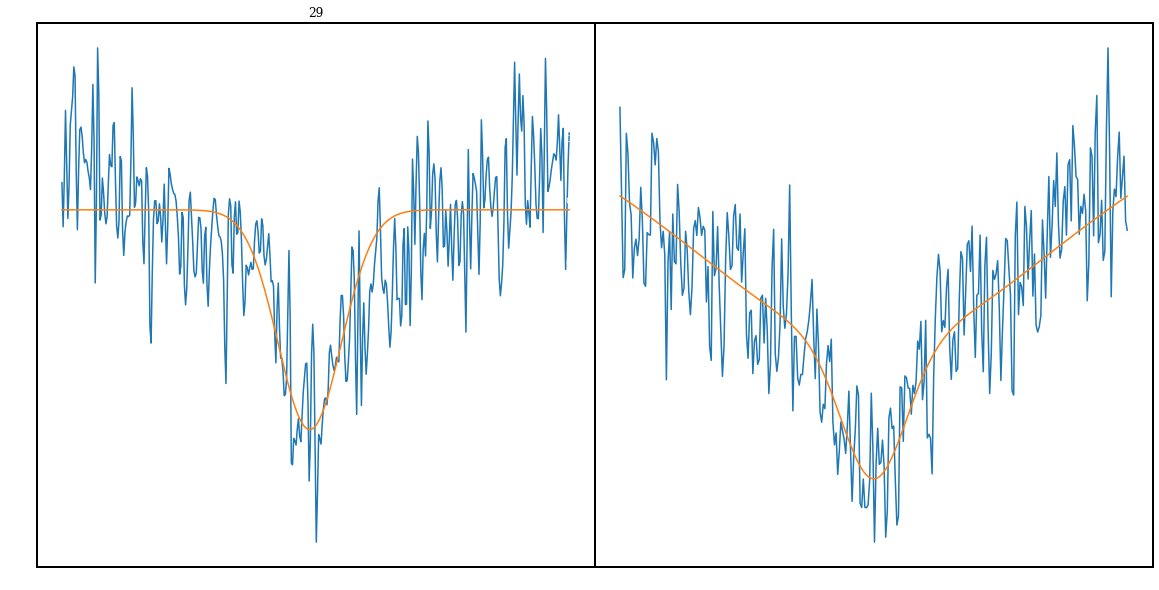

Parameters([('cen', <Parameter 'cen', value=3.8171551770613745, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-5.645540280596606e-05, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=4.2745046606729176e-06, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=-41487.96860931319, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.11292757892134064, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=41488.3722596647, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.286196147728792, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0004677429887425255, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=188868.24114445335, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.10795981313650471, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-188867.27245867706,

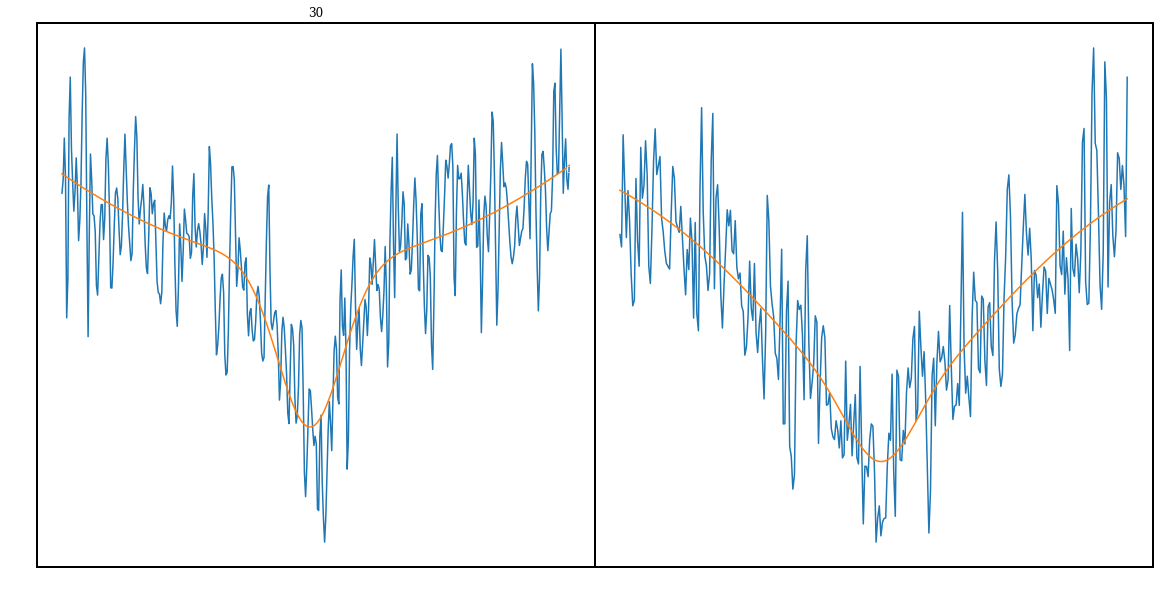

Parameters([('cen', <Parameter 'cen', value=3.817131113751232, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-1.2580500851379401, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0021564155276343477, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.6797858341410762, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.07572784345751482, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=0.9597785751847699, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.22452399244647192, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0003008168708282799, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=0.4564015213036962, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.04647996016152511, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.40653235546261773, 

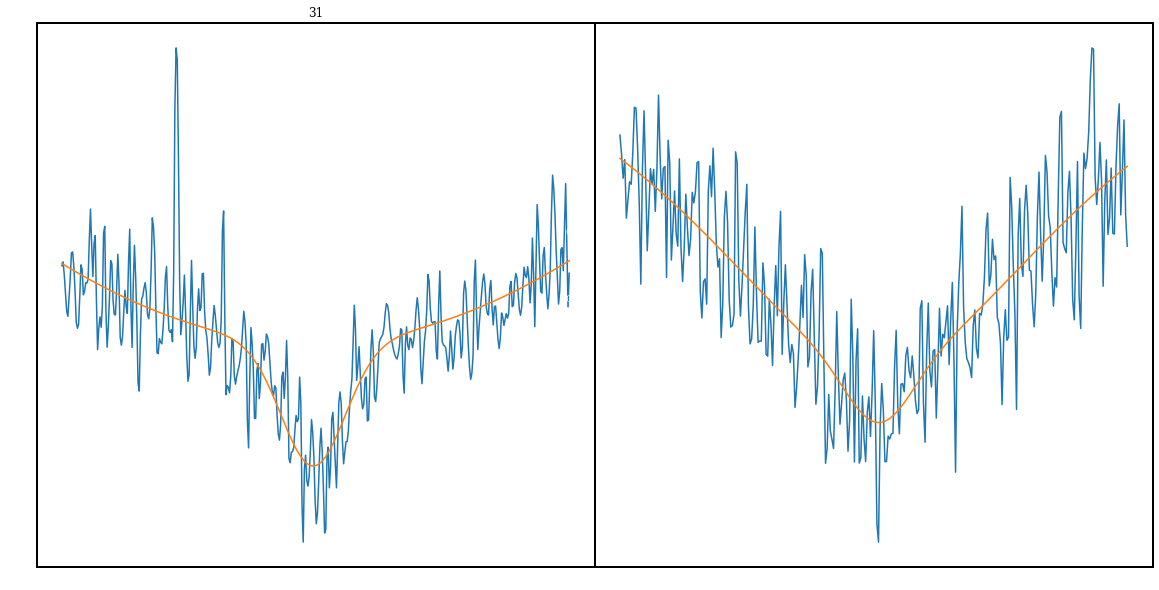

Parameters([('cen', <Parameter 'cen', value=3.81712882814177, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-1.467021934987907, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0021363899316155788, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=0.7838528323154567, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.0759558325073657, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=1.06384358928315, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.2891104466074568, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00038278629668964115, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=0.4946000763713489, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.04208062166601223, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=0.4449709706254665, bounds

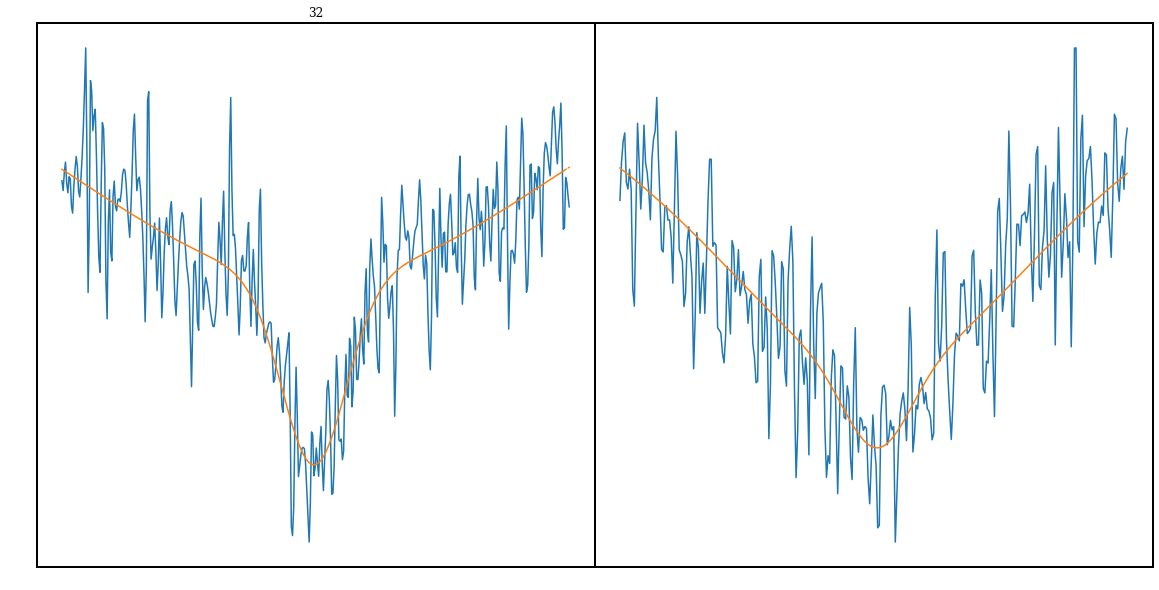

Parameters([('cen', <Parameter 'cen', value=3.8171374848219153, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.30676246448228417, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=0.0006864219462685561, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=-163356.217259868, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.12890782912873133, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=163357.1484511313, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.2193638470700634, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.00039625472916404725, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=-184124.1677721216, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.04114906652840644, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=184124.8752946789, bo

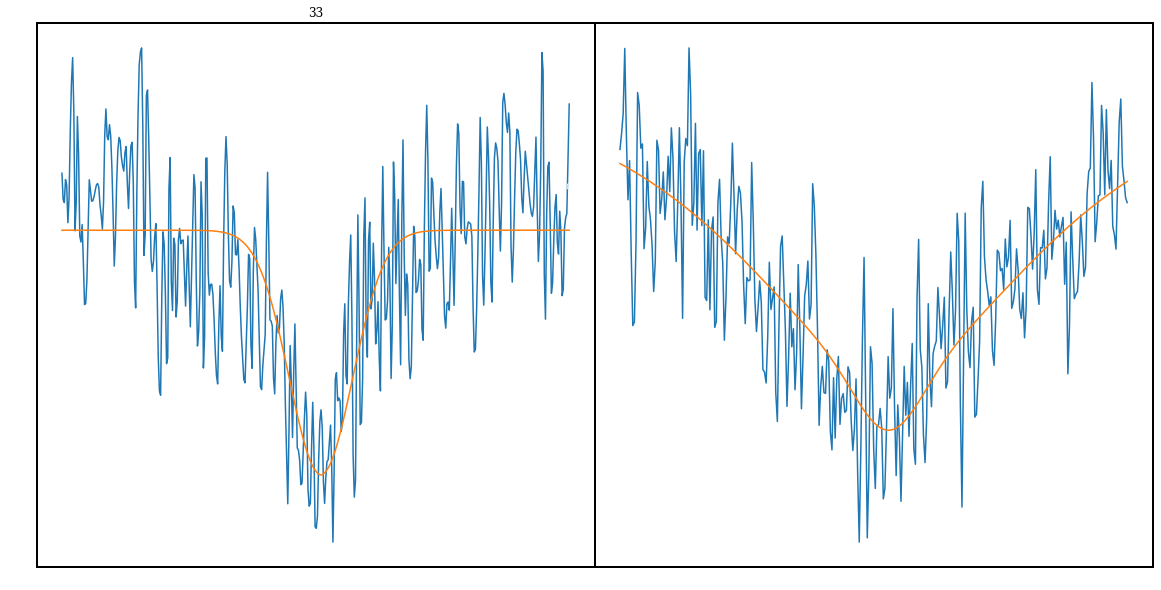

Parameters([('cen', <Parameter 'cen', value=3.8171390998871226, bounds=[-inf:inf]>), ('ampAL', <Parameter 'ampAL', value=-0.0005441598148958615, bounds=[-inf:-1e-30]>), ('gamA', <Parameter 'gamA', value=3.813559740217798e-06, bounds=[1e-30:inf]>), ('offAL', <Parameter 'offAL', value=216012.41415475743, bounds=[-inf:inf]>), ('ampA', <Parameter 'ampA', value=-0.16557653731273025, bounds=[-1:1e-30]>), ('widA', <Parameter 'widA', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offA', <Parameter 'offA', value=-216011.76078640888, bounds=[-inf:inf]>), ('ampBL', <Parameter 'ampBL', value=-0.1808058547685305, bounds=[-inf:1e-30]>), ('gamB', <Parameter 'gamB', value=0.0003138705091090266, bounds=[1e-30:inf]>), ('offBL', <Parameter 'offBL', value=637613.0703341507, bounds=[-inf:inf]>), ('ampB', <Parameter 'ampB', value=-0.032666625951698114, bounds=[-1:1e-30]>), ('widB', <Parameter 'widB', value=4.999999969612645e-09, bounds=[1e-30:inf]>), ('offB', <Parameter 'offB', value=-637612.393488428

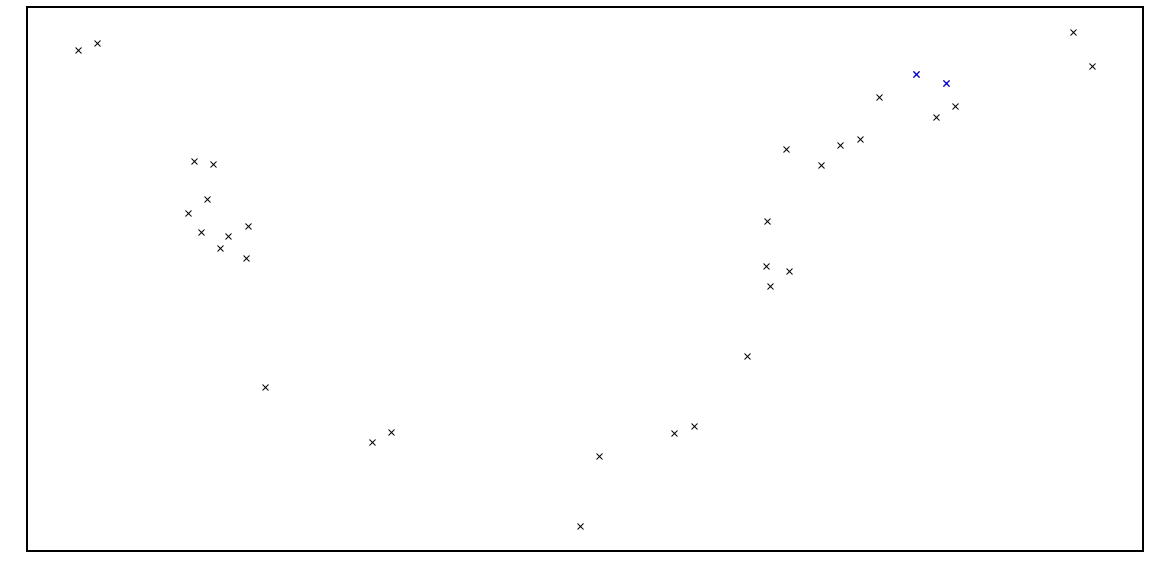

In [5]:
def fit_function(params, x1=None, x2=None, dat1=None, dat2=None):
    #1 is alpha 6562.801
    #4861.363 be -0.13033118436
    #ga 4340.472
    model1 = lorentzianGauss(x1, params['cen'],params['ampAL'],params['gamA'], params['offAL'], params['ampA'],params['widA'], params['offA']) #alpha
    model2 = lorentzianGauss(x2, params['cen']-0.13033118436,params['ampBL'],params['gamB'], params['offBL'], params['ampB'],params['widB'], params['offB']) #beta
    resid1 = dat1 - model1
    resid2 = dat2 - model2
    return np.concatenate((resid1, resid2))


params = Parameters()
params.add('cen', value=np.log10(6563))
params.add('ampAL', value=-0.08)#, min=-1, max=0)
params.add('gamA', value=0.0004)
params.add('offAL', value=0.)#, min=0.001,max=1)
params.add('ampA', value=-0.05, min=-1, max=1e-30)
params.add('widA', value=0.000000005, min=1e-30)
params.add('offA', value=0.28)#,min=0.001,max=1)
#be
params.add('ampBL', value=-0.1)#, min=-1, max=0)
params.add('gamB', value=0.0002)
params.add('offBL', value=0.5)#, min=0.001,max=1)
params.add('ampB', value=-0.0004, min=-1, max=1e-30)
params.add('widB', value=0.000000005, min=1e-30)
params.add('offB', value=0.45)#, min=0.001,max=1)


path = '/home/nwal/Desktop/GD1400/reflexFin/'
fluxes = []
wavels = []
count = 0
with open(path+'Stitched') as file:
    for line in file:
        line = line.strip('\n')
        line = path+line
        wvl, flx = pyasl.read1dFitsSpec(line)
        wvl = np.log10(wvl)
        flx = flx/np.median(flx)
        fluxes.append([flx])
        wavels.append([wvl])
        count = count+1
path = '/home/nwal/Desktop/GD1400/reflexFin/'
dates2 = []
with open(path+'Stitched') as file:
    for line in file:
        line = line.strip('\n')
        line = path+line
        hdul = fits.open(line)
        dates2.append(hdul[0].header['MJD-OBS']+0.00347)
        hdul.close()

wavelsAng = np.array(wavels)

count = 0
globalOff = []
for el in fluxes:
    
    #alpha
    mod = Model(gaussian)
    indexSt = find_nearest(wavelsAng[count][0], 3.8169)
    indexFi = find_nearest(wavelsAng[count][0], 3.8173)
    fluxIn = fluxes[count][0][indexSt:indexFi+1]
    pixels = wavelsAng[count][0][indexSt:indexFi+1]
    pars = Parameters()
    pars.add('amp', value=-0.06, min=-1, max=1e-30)
    pars.add('cen', value=np.log10(6563))
    pars.add('wid', value=0.000000005, min=1e-30)
    pars.add('off', value=0.26)
    result = mod.fit(fluxIn,pars,x=pixels)
    cenEst = result.params['cen'].value
    indexSt = find_nearest(wavelsAng[count][0], cenEst-0.0004)
    indexFi = find_nearest(wavelsAng[count][0], cenEst+0.0004)
    fluxIn = fluxes[count][0][indexSt:indexFi+1]
    pixels = wavelsAng[count][0][indexSt:indexFi+1]
    x1Final = pixels
    dat1Final = fluxIn
    #beta
    mod = Model(gaussian)
    indexSt = find_nearest(wavelsAng[count][0], np.log10(4860))
    indexFi = find_nearest(wavelsAng[count][0], np.log10(4862.5))
    fluxIn = fluxes[count][0][indexSt:indexFi+1]
    pixels = wavelsAng[count][0][indexSt:indexFi+1]
    pars = mod.make_params(amp=-0.06,cen=np.log10(4862),wid=0.000000005,off=0.45)
    result = mod.fit(fluxIn,pars,x=pixels)
    cenEst = result.params['cen'].value
    indexSt = find_nearest(wavelsAng[count][0], cenEst-0.0004)
    indexFi = find_nearest(wavelsAng[count][0], cenEst+0.0004)
    fluxIn = fluxes[count][0][indexSt:indexFi+1]
    pixels = wavelsAng[count][0][indexSt:indexFi+1]
    x2Final = pixels
    dat2Final = fluxIn
    out = minimize(fit_function, params, args=(x1Final, x2Final, dat1Final, dat2Final))
    globalOff.append(out.params['cen'].value)
    count = count+1
    
    
    

    rc('axes', linewidth=2)

    fig, axs = plt.subplots(1, 2,
                        gridspec_kw={'hspace': 0.0, 'wspace': 0.0}, figsize=(20,10))
    axs[0].set_title(str(count-1))
    axs[0].plot(x1Final,dat1Final)
    axs[0].plot(x1Final, lorentzianGauss(x1Final, out.params['cen'],out.params['ampAL'],out.params['gamA'], out.params['offAL'], out.params['ampA'],out.params['widA'], out.params['offA']))
    axs[1].plot(x2Final,dat2Final)
    axs[1].plot(x2Final, lorentzianGauss(x2Final, out.params['cen']-0.13033118436,out.params['ampBL'],out.params['gamB'], out.params['offBL'], out.params['ampB'],out.params['widB'], out.params['offB']))
    plt.show()
    print(out.params)
    #break
    params = Parameters()
    params.add('cen', value=np.log10(6563))
    params.add('ampAL', value=-0.08, max=-1e-30)
    params.add('gamA', value=0.0004,min=1e-30)
    params.add('offAL', value=0.)#, min=0.001,max=1)
    params.add('ampA', value=-0.05, min=-1, max=1e-30)
    params.add('widA', value=0.000000005, min=1e-30)
    params.add('offA', value=0.28)#,min=0.001,max=1)
    #be
    params.add('ampBL', value=-0.1, max=1e-30)
    params.add('gamB', value=0.0002, min=1e-30)
    params.add('offBL', value=0.5)#, min=0.001,max=1)
    params.add('ampB', value=-0.0004, min=-1, max=1e-30)
    params.add('widB', value=0.000000005, min=1e-30)
    params.add('offB', value=0.45)#, min=0.001,max=1)
    
    #errorsTwo.append(out.params['offsetx'].stderr)
    
#>>> # keck = EarthLocation.of_site('Keck')  # the easiest way... but requires internet
esovlt = EarthLocation.from_geodetic(lat=-24.6275*u.deg, lon=-70.4044*u.deg, height=2635*u.m)
sc = SkyCoord("01:47:21.8246239967 -21:56:51.387203270", frame=ICRS, unit=(u.hourangle, u.deg))
baryCorr = []
for el in dates2:
    barycorr = sc.radial_velocity_correction(obstime=Time(el, format='mjd'), location=esovlt)  
    baryCorr.append(barycorr.to(u.km/u.s).value)
print(baryCorr)


offsetsAlpha = 10**np.array(globalOff)

offsetsAlphaS = offsetsAlpha

halpharest = 6562.801 #air
offsetsAlphaS = (offsetsAlphaS - halpharest)/halpharest
offsetsAlphaS = (offsetsAlphaS)*(299792458/1000)
print(offsetsAlphaS)
offsetsAlphaS = np.array(offsetsAlphaS) + baryCorr

phases = foldMeth(np.array(dates2)+0.09, 1/15.10234435018197*(2*np.pi))

plt.figure(figsize=(20,10))
plt.plot(phases,offsetsAlphaS, 'kx')
plt.plot(phases[-2:],offsetsAlphaS[-2:], 'bx')

UVESY = offsetsAlphaS

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a     199.2     -inf      inf   0.5666     True     None     None
c    -1.958     -inf      inf 0.002867     True     None     None
d     15.64     -inf      inf   0.4066     True     None     None
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a     24.54     -inf      inf    1.007     True     None     None
c     5.953     -inf      inf  0.02642     True     None     None
d     40.99     -inf      inf   0.5545     True     None     None


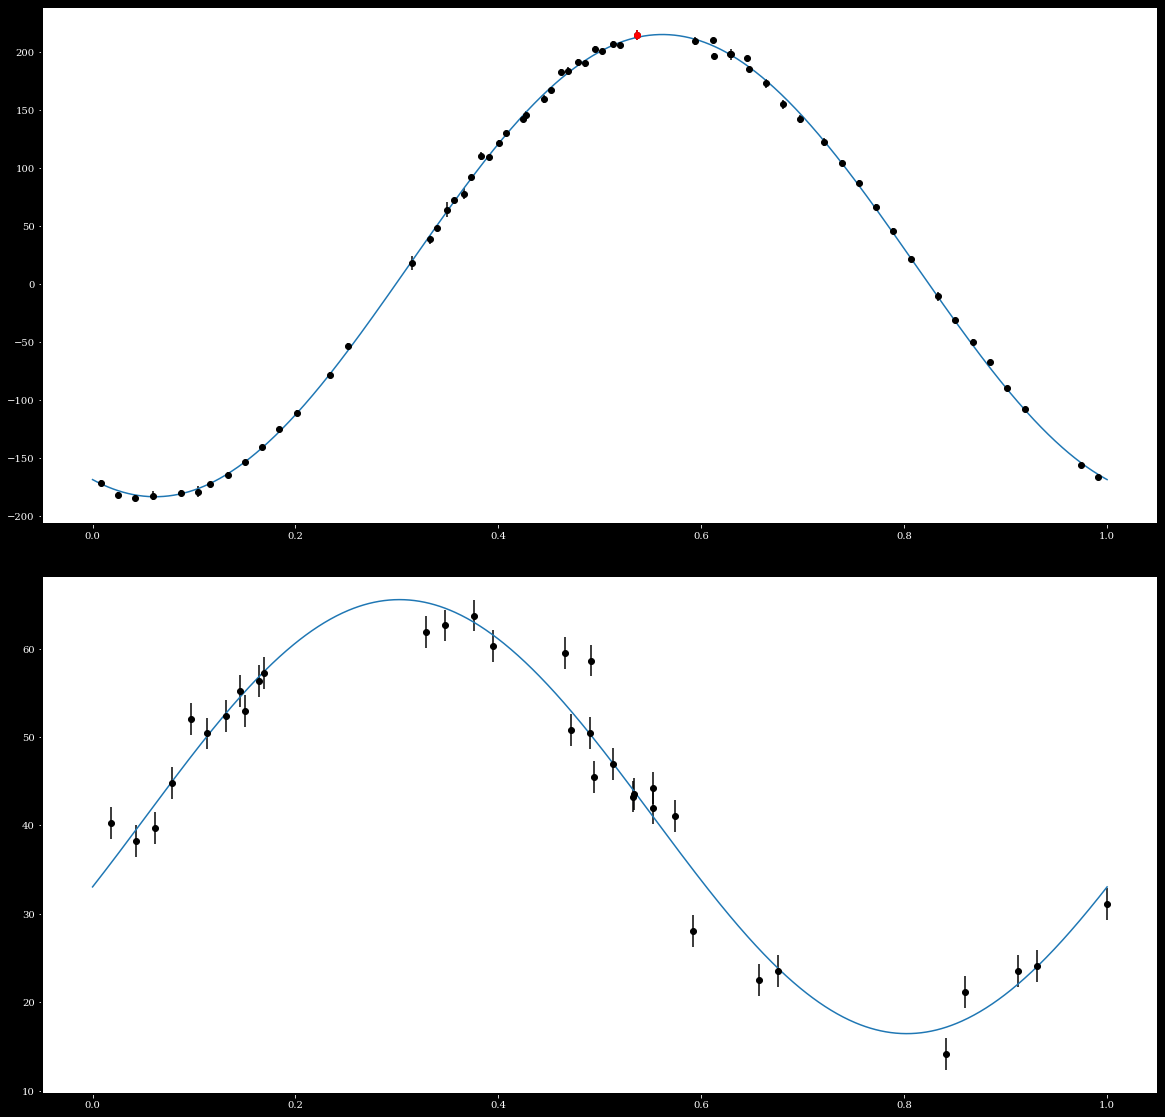

In [11]:
UVEST=dates2
allallT = np.concatenate((ISAACT1,ISAACT2,UVEST))
allallF = np.concatenate((ISAACY1,ISAACY2,UVESY))

UVESFold = foldMeth(UVEST,9.978/24)
allallE =np.concatenate((ISAACE1,ISAACE2,1.8*np.ones_like(UVESFold)))

phasesFold = foldMeth(allallT,9.978/24)
f,(ax,ax2) = plt.subplots(2,1,gridspec_kw={'hspace': 0.1, 'wspace': 0.05}, facecolor='k', figsize=(20,20))



mod = Model(sineModelFix)
pars = mod.make_params(a=200,b=1,c=0,d=100)
result = mod.fit(allallF[:62],pars,x=phasesFold[:62])
TDummy = np.linspace(0,1,1000)
ypointsModel = sineModelFix(TDummy,result.params['a'].value,result.params['c'].value,result.params['d'].value)
ypointsModelKeep = 
ax.plot(TDummy,ypointsModel)
ax.errorbar(phasesFold[:62],allallF[:62],yerr=allallE[:62],ls='',c='k',marker='o')
idxTry = 9
ax.errorbar(phasesFold[idxTry],allallF[idxTry],yerr=allallE[idxTry],ls='',c='r',marker='o')

result.params.pretty_print()

mod = Model(sineModelFix)
pars = mod.make_params(a=25,b=2,c=4.5,d=50)
#UVESFold = foldMeth(UVEST,0.41574154920793316)
UVESFold = foldMeth(UVEST,9.978/24)
result = mod.fit(UVESY,pars,x=UVESFold)
TDummy = np.linspace(0,1,1000)
ypointsModel = sineModelFix(TDummy,result.params['a'].value,result.params['c'].value,result.params['d'].value)
result.params.pretty_print()
ax2.errorbar(phasesFold[-34:],allallF[-34:],yerr=allallE[-34:],ls='', c='k',marker='o')
ax2.plot(TDummy,ypointsModel)

#0.5
#ypointsModel = sineModel(TDummy,result.params['a'].value,result.params['b'].value,result.params['c'].value,result.params['d'].value)
#result.params.pretty_print()

#ax2.plot(TDummy,ypointsModel,c='r')

In [12]:
40.99-15.64

25.35

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a     199.2     -inf      inf   0.5666     True     None     None
c    -1.958     -inf      inf 0.002867     True     None     None
d     15.64     -inf      inf   0.4066     True     None     None


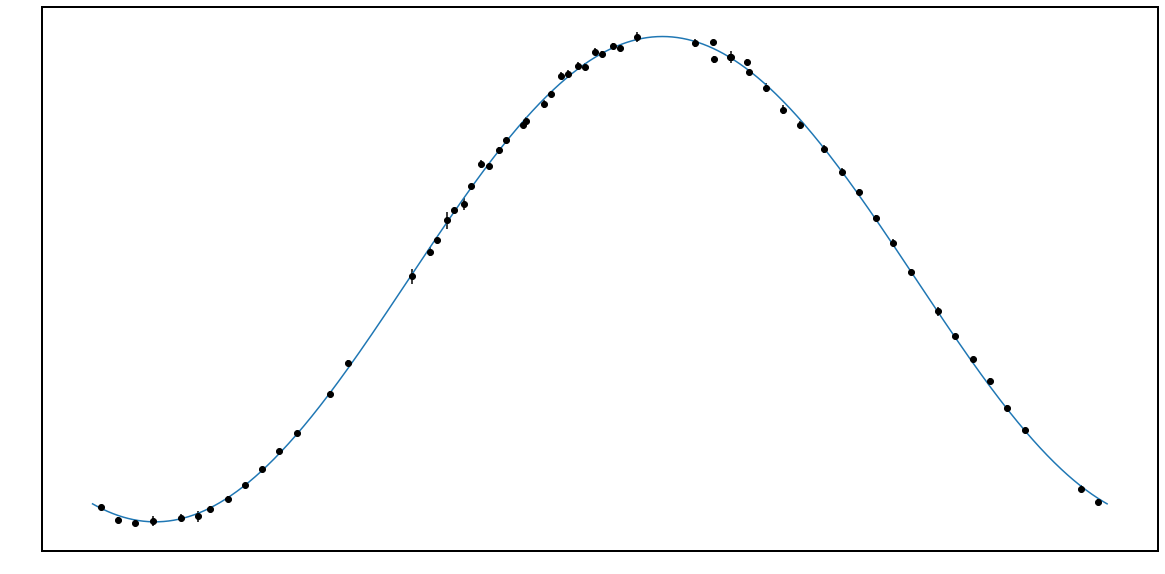

In [14]:
allT = np.concatenate((ISAACT1,ISAACT2))
allF = np.concatenate((ISAACY1,ISAACY2))
allE =np.concatenate((ISAACE1,ISAACE2))
fold = foldMeth(allT,9.978/24)

plt.figure(figsize=(20,10))
mod = Model(sineModelFix)
pars = mod.make_params(a=200,b=1,c=0,d=100)
result = mod.fit(allF,pars,x=fold)
TDummy = np.linspace(0,1,1000)
ypointsModel = sineModelFix(TDummy,result.params['a'].value,result.params['c'].value,result.params['d'].value)
plt.plot(TDummy,ypointsModel)
plt.errorbar(fold,allF,yerr=allE,ls='',c='k',marker='o')
result.params.pretty_print()



In [16]:
allT

array([55498.10712249, 55498.11416601, 55498.13545418, 55498.15624346,
       55498.19994736, 55498.20699088, 55498.22825531, 55498.24654623,
       55498.25358977, 55498.27485559, 55498.31351272, 55498.32055625,
       55498.34182215, 55498.10000106, 55498.12129075, 55498.12833427,
       55498.14914461, 55498.19284914, 55498.21411506, 55498.22115857,
       55498.23942391, 55498.26068735, 55498.26773087, 55498.30638181,
       55498.32768057, 55498.33472409, 55499.02138636, 55499.0284299 ,
       55499.04971992, 55499.06807657, 55499.07512009, 55499.09640733,
       55499.13737101, 55499.14441453, 55499.19021475, 55499.19725827,
       55499.21853749, 55499.23686178, 55499.24390534, 55499.26522818,
       55499.29537973, 55499.3024233 , 55499.32371061, 55499.34218465,
       55499.01426134, 55499.03555141, 55499.04259493, 55499.06097832,
       55499.0822441 , 55499.08928762, 55499.13023963, 55499.15152438,
       55499.18309381, 55499.20437316, 55499.21141666, 55499.22973661,
      

In [17]:
fold

array([0.133187  , 0.15012871, 0.20133296, 0.25133725, 0.35645786,
       0.37339959, 0.42454674, 0.46854176, 0.48548352, 0.536634  ,
       0.62961569, 0.64655743, 0.69770812, 0.11605787, 0.16726579,
       0.1842075 , 0.23426243, 0.33938458, 0.39053533, 0.40747703,
       0.45141048, 0.50255526, 0.51949699, 0.61246378, 0.66369349,
       0.6806352 , 0.33225823, 0.3492    , 0.4004087 , 0.4445618 ,
       0.46150354, 0.51270554, 0.61123513, 0.62817687, 0.73833974,
       0.75528146, 0.80646421, 0.85053946, 0.86748127, 0.91876893,
       0.99129219, 0.00823404, 0.05943624, 0.10387168, 0.31512047,
       0.36632931, 0.38327102, 0.42748843, 0.47863884, 0.49558057,
       0.59408209, 0.64527812, 0.72121181, 0.77239485, 0.78933653,
       0.83340134, 0.88461552, 0.90155722, 0.97413271, 0.02536948,
       0.04231129, 0.08674177])

In [39]:
sineModelFix(0.811675,result.params['a'].value,result.params['c'].value,result.params['d'].value)

15.640948797982402

In [ ]:
15.64 #up decreases


0.811675

In [64]:
foldMeth([55498.389205],9.978/24)[0]

0.8116776909218834